In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pickle
from matplotlib import colors
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency
from statsmodels.tools.eval_measures import aic, bic
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = Path('data/appartments_train.csv')

In [5]:
df = pd.read_csv(file_path, sep=',')

In [7]:
df.head()

,unit_id,obj_type,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,...,price_z,src_month,loc_code,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
0,a3a463617a5c0439,0d6c4dfc,45.89,2.0,1.0,4.0,1999.0,13.496,11.0,0.541,...,519626.21,2023-09,693f303c,501710.76,14.02,95.39,44.51,0.999,13.99,100.291946
1,23a92531fcb238b4,0c238f18,27.64,1.0,1.0,2.0,1940.0,2.440,16.0,0.377,...,162959.26,2024-04,8d5a4f0c,147763.87,110.55,46.17,56.25,1.000,7.59,91.315644
2,d158671401f9fc34,0d6c4dfc,62.18,2.0,1.0,2.0,2000.0,10.284,8.0,0.391,...,1167571.51,2023-10,693f303c,1042847.59,31.15,18.94,50.36,0.999,21.14,93.681619
3,280aced4655b7a96,2a6d5c01,53.68,2.0,NaN,4.0,2018.0,10.589,30.0,0.729,...,907071.16,2024-01,693f303c,728839.39,7.52,11.84,46.69,0.999,7.91,94.192062
4,2315fa621e746fe4,2a6d5c01,70.89,3.0,2.0,3.0,2015.0,8.305,7.0,1.226,...,1080383.19,2023-11,693f303c,1263171.15,11.20,89.64,45.60,0.999,8.63,96.166051


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156454 entries, 0 to 156453
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   unit_id                     156454 non-null  object 
 1   obj_type                    122634 non-null  object 
 2   dim_m2                      156454 non-null  float64
 3   n_rooms                     156454 non-null  float64
 4   floor_no                    128756 non-null  float64
 5   floor_max                   154533 non-null  float64
 6   year_built                  130741 non-null  float64
 7   dist_centre                 156454 non-null  float64
 8   n_poi                       156454 non-null  float64
 9   dist_sch                    156324 non-null  float64
 10  dist_clinic                 155883 non-null  float64
 11  dist_post                   156266 non-null  float64
 12  dist_kind                   156291 non-null  float64
 13  dist_rest     

In [13]:
columns_with_missings = df.columns[df.isnull().any()]

In [15]:
df[columns_with_missings].isnull().sum()

obj_type                   33820
floor_no                   27698
floor_max                   1921
year_built                 25713
dist_sch                     130
dist_clinic                  571
dist_post                    188
dist_kind                    163
dist_rest                    391
dist_uni                    4317
dist_pharma                  219
build_mat                  61999
cond_class                117058
has_lift                    7727
infrastructure_quality     25713
dtype: int64

In [17]:
# frequency tables for these columns
print('Frequency counts for obj_type: \n')
print(df['obj_type'].value_counts(dropna=False))

Frequency counts for obj_type: 

obj_type
0d6c4dfc    73136
NaN         33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64


In [19]:
'''
Treat NaN as a separate category (e.g., "Unknown" or "Missing") rather than 
dropping or imputing. This keeps data and avoids losing info.
'''

'\nTreat NaN as a separate category (e.g., "Unknown" or "Missing") rather than \ndropping or imputing. This keeps data and avoids losing info.\n'

In [21]:
# frequency tables for these columns
print('Frequency counts for floor_no: \n')
print(df['floor_no'].value_counts(dropna=False))

Frequency counts for floor_no: 

floor_no
1.0     30396
NaN     27698
3.0     27034
2.0     26939
4.0     19173
5.0      7361
6.0      4481
7.0      3521
8.0      2710
9.0      2336
10.0     2224
11.0      902
12.0      508
14.0      334
13.0      258
15.0      206
17.0      155
16.0       92
20.0       25
18.0       25
24.0       19
29.0       14
23.0       14
22.0       11
25.0        6
21.0        6
19.0        5
27.0        1
Name: count, dtype: int64


In [23]:
'''
Do NOT drop NaNs (27,698 missing is large).

Impute NaNs with a special value (e.g., -1) or create a "Missing" indicator feature.

Floor is numeric and likely impacts price, so keep it.

Consider capping very high floors or grouping rare high floors into one category 
to reduce noise.
'''

'\nDo NOT drop NaNs (27,698 missing is large).\n\nImpute NaNs with a special value (e.g., -1) or create a "Missing" indicator feature.\n\nFloor is numeric and likely impacts price, so keep it.\n\nConsider capping very high floors or grouping rare high floors into one category \nto reduce noise.\n'

In [25]:
# frequency tables for these columns
print('Frequency counts for floor_max: \n')
print(df['floor_max'].value_counts(dropna=False))

Frequency counts for floor_max: 

floor_max
4.0     48935
3.0     28889
5.0     15378
10.0    14002
2.0     12042
6.0      8590
7.0      5662
8.0      4533
11.0     4199
1.0      3556
9.0      2049
NaN      1921
12.0     1712
15.0     1176
17.0      930
16.0      790
13.0      691
14.0      548
18.0      191
23.0      111
19.0      106
24.0       97
22.0       84
20.0       61
25.0       58
27.0       53
29.0       35
26.0       24
28.0       18
21.0       13
Name: count, dtype: int64


In [27]:
'''
Small amount of NaNs (1,921), so impute with median (around 4 or 5).

Keep as numeric feature since it likely affects price.

No need to create missing category here due to low missingness.
'''

'\nSmall amount of NaNs (1,921), so impute with median (around 4 or 5).\n\nKeep as numeric feature since it likely affects price.\n\nNo need to create missing category here due to low missingness.\n'

In [29]:
# frequency tables for these columns
print('Frequency counts for year_built: \n')
print(df['year_built'].value_counts(dropna=False))

Frequency counts for year_built: 

year_built
NaN       25713
2023.0     7528
2022.0     6263
1980.0     5432
1970.0     5293
          ...  
1884.0        2
1861.0        2
1855.0        2
1864.0        1
1866.0        1
Name: count, Length: 166, dtype: int64


In [31]:
'''
High NaNs (25,713), impute with median year or a placeholder (e.g., 1900) if many old buildings.

Alternatively, create a "Missing" flag to capture missingness effect.

Keep as numeric (maybe also create age = current_year - year_built).
'''

'\nHigh NaNs (25,713), impute with median year or a placeholder (e.g., 1900) if many old buildings.\n\nAlternatively, create a "Missing" flag to capture missingness effect.\n\nKeep as numeric (maybe also create age = current_year - year_built).\n'

In [33]:
# frequency tables for these columns
print('Frequency counts for dist_sch: \n')
print(df['dist_sch'].value_counts(dropna=False))

Frequency counts for dist_sch: 

dist_sch
0.155    403
0.145    401
0.179    399
0.205    394
0.174    392
        ... 
1.608      1
3.372      1
3.250      1
2.618      1
2.908      1
Name: count, Length: 3613, dtype: int64


In [35]:
'''
Very few missing (130), so impute with median or mean.

Keep as numeric feature.
'''

'\nVery few missing (130), so impute with median or mean.\n\nKeep as numeric feature.\n'

In [37]:
# frequency tables for these columns
print('Frequency counts for dist_clinic: \n')
print(df['dist_clinic'].value_counts(dropna=False))

Frequency counts for dist_clinic: 

dist_clinic
NaN      571
0.303    190
0.299    181
0.271    174
0.294    172
        ... 
4.425      1
4.691      1
4.962      1
4.742      1
4.975      1
Name: count, Length: 4909, dtype: int64


In [39]:
'''
Moderate missing (571), impute with median.

Keep as numeric feature.
'''

'\nModerate missing (571), impute with median.\n\nKeep as numeric feature.\n'

In [41]:
# frequency tables for these columns
print('Frequency counts for dist_post: \n')
print(df['dist_post'].value_counts(dropna=False))

Frequency counts for dist_post: 

dist_post
0.261    304
0.245    293
0.284    289
0.209    285
0.252    284
        ... 
4.431      1
2.802      1
5.045      1
3.602      1
2.081      1
Name: count, Length: 3801, dtype: int64


In [43]:
'''
Few missing (188), impute with median.

Keep as numeric feature.
'''

'\nFew missing (188), impute with median.\n\nKeep as numeric feature.\n'

In [45]:
# frequency tables for these columns
print('Frequency counts for dist_kind: \n')
print(df['dist_kind'].value_counts(dropna=False))

Frequency counts for dist_kind: 

dist_kind
0.161    442
0.158    441
0.112    435
0.173    433
0.141    433
        ... 
2.314      1
4.366      1
2.661      1
3.959      1
3.646      1
Name: count, Length: 3574, dtype: int64


In [47]:
'''
Very few missing (163), impute with median.

Keep as numeric feature.
'''

'\nVery few missing (163), impute with median.\n\nKeep as numeric feature.\n'

In [49]:
# frequency tables for these columns
print('Frequency counts for dist_rest: \n')
print(df['dist_rest'].value_counts(dropna=False))

Frequency counts for dist_rest: 

dist_rest
0.061    480
0.065    475
0.068    470
0.066    470
0.070    463
        ... 
2.420      1
3.823      1
3.027      1
2.071      1
2.856      1
Name: count, Length: 3557, dtype: int64


In [51]:
'''
Moderate missing (391), impute with median.

Keep as numeric feature.
'''

'\nModerate missing (391), impute with median.\n\nKeep as numeric feature.\n'

In [53]:
# frequency tables for these columns
print('Frequency counts for dist_uni: \n')
print(df['dist_uni'].value_counts(dropna=False))

Frequency counts for dist_uni: 

dist_uni
NaN      4317
0.485     124
0.588     110
0.523     110
0.323     109
         ... 
5.694       1
5.744       1
5.603       1
5.217       1
5.310       1
Name: count, Length: 5539, dtype: int64


In [55]:
'''
High missing (4,317), impute with median.

Optionally add missing indicator.

Keep numeric.
'''

'\nHigh missing (4,317), impute with median.\n\nOptionally add missing indicator.\n\nKeep numeric.\n'

In [57]:
# frequency tables for these columns
print('Frequency counts for dist_pharma: \n')
print(df['dist_pharma'].value_counts(dropna=False))

Frequency counts for dist_pharma: 

dist_pharma
0.167    486
0.133    472
0.165    464
0.156    463
0.163    462
        ... 
3.589      1
4.605      1
2.716      1
4.061      1
3.973      1
Name: count, Length: 3583, dtype: int64


In [59]:
'''
Few missing (219), impute with median.

Keep numeric.
'''

'\nFew missing (219), impute with median.\n\nKeep numeric.\n'

In [61]:
# frequency tables for these columns
print('Frequency counts for build_mat: \n')
print(df['build_mat'].value_counts(dropna=False))

Frequency counts for build_mat: 

build_mat
7ceffe3b    73414
NaN         61999
7f8c00f9    21041
Name: count, dtype: int64


In [63]:
'''
Large NaNs (61,999), so treat NaN as separate category ("Missing").

Encode all categories (including "Missing") with one-hot or target encoding.

Categorical = variable represents categories, not numeric values.
Anonymized = categories are replaced by codes/IDs to hide real material names.
'''

'\nLarge NaNs (61,999), so treat NaN as separate category ("Missing").\n\nEncode all categories (including "Missing") with one-hot or target encoding.\n\nCategorical = variable represents categories, not numeric values.\nAnonymized = categories are replaced by codes/IDs to hide real material names.\n'

In [65]:
# frequency tables for these columns
print('Frequency counts for cond_class: \n')
print(df['cond_class'].value_counts(dropna=False))

Frequency counts for cond_class: 

cond_class
NaN         117058
a2881958     22298
53cced8d     17098
Name: count, dtype: int64


In [67]:
'''
Very high NaNs (117,058), so treat NaN as separate "Missing" category.

Encode categories including "Missing".
'''

'\nVery high NaNs (117,058), so treat NaN as separate "Missing" category.\n\nEncode categories including "Missing".\n'

In [69]:
# frequency tables for these columns
print('Frequency counts for has_lift: \n')
print(df['has_lift'].value_counts(dropna=False))

Frequency counts for has_lift: 

has_lift
no     74680
yes    74047
NaN     7727
Name: count, dtype: int64


In [73]:
'''
Small missing (7,727), treat NaN as a separate category or impute with mode 
("no" or "yes").

Encode as binary (0/1) including missing if separate category.
'''

'\nSmall missing (7,727), treat NaN as a separate category or impute with mode \n("no" or "yes").\n\nEncode as binary (0/1) including missing if separate category.\n'

In [75]:
# frequency tables for these columns
print('Frequency counts for infrastructure_quality: \n')
print(df['infrastructure_quality'].value_counts(dropna=False))

Frequency counts for infrastructure_quality: 

infrastructure_quality
NaN       25713
0.00       1784
1.44        124
1.39        124
1.08        119
          ...  
107.39        1
169.58        1
135.58        1
137.15        1
170.64        1
Name: count, Length: 15191, dtype: int64


In [77]:
'''
High NaNs (25,713), impute with median.

Keep numeric feature.
'''

'\nHigh NaNs (25,713), impute with median.\n\nKeep numeric feature.\n'

## Fillna with description provided and Data Frequencies

In [82]:
df_copy = df.copy() # just for insurance of our code

In [88]:
# obj_type - Unknown
df.obj_type.fillna('Unknown', inplace = True)
# floor_no - -1 (Unknown)
df.floor_no.fillna(-1, inplace = True)
# floor_max - median()
df.floor_max.fillna(df.floor_max.median(), inplace=True)
# year_built - median()
df.year_built.fillna(df.year_built.median(), inplace=True)
# dist_sch - median()
df.dist_sch.fillna(df.dist_sch.median(), inplace=True)
# dist_clinic - median()
df.dist_clinic.fillna(df.dist_clinic.median(), inplace=True)
# dist_post - median()
df.dist_post.fillna(df.dist_post.median(), inplace=True)
# dist_kind - median()
df.dist_kind.fillna(df.dist_kind.median(), inplace=True)
# dist_rest - median()
df.dist_rest.fillna(df.dist_rest.median(), inplace=True)
# dist_uni - median()
df.dist_uni.fillna(df.dist_uni.median(), inplace=True)
# dist_pharma - median()
df.dist_pharma.fillna(df.dist_pharma.median(), inplace=True)
# build_mat - Unknown
df.build_mat.fillna('Unknown', inplace=True)
# cond_class - Unknown
df.cond_class.fillna('Unknown', inplace=True)
# has_lift - random-choice 0.5
nan_mask = df['has_lift'].isna()
n_nan = nan_mask.sum()
df.loc[nan_mask, 'has_lift'] = np.random.choice(['yes', 'no'], size=n_nan, p=[0.5, 0.5])
# infrastructure_quality - median()
df.infrastructure_quality.fillna(df.infrastructure_quality.median(), inplace=True)

In [96]:
# checking if handling missing values worked or not
for col in columns_with_missings:
    print('-------------------------------------')
    print(f'Frequency table for {col}: ')
    print(df[col].value_counts(dropna=False))
    print('-------------------------------------')

-------------------------------------
Frequency table for obj_type: 
obj_type
0d6c4dfc    73136
Unknown     33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64
-------------------------------------
-------------------------------------
Frequency table for floor_no: 
floor_no
 1.0     30396
-1.0     27698
 3.0     27034
 2.0     26939
 4.0     19173
 5.0      7361
 6.0      4481
 7.0      3521
 8.0      2710
 9.0      2336
 10.0     2224
 11.0      902
 12.0      508
 14.0      334
 13.0      258
 15.0      206
 17.0      155
 16.0       92
 20.0       25
 18.0       25
 24.0       19
 29.0       14
 23.0       14
 22.0       11
 25.0        6
 21.0        6
 19.0        5
 27.0        1
Name: count, dtype: int64
-------------------------------------
-------------------------------------
Frequency table for floor_max: 
floor_max
4.0     50856
3.0     28889
5.0     15378
10.0    14002
2.0     12042
6.0      8590
7.0      5662
8.0      4533
11.0     4199
1.0      3556
9.0 

In [98]:
'''

numerical and categorical variables

'''

'\n\nnumerical and categorical variables\n\n'

In [103]:
df_categorical_variables = df_train.select_dtypes('object').columns
df_numerical_variables = df_train.select_dtypes(include=[np.number]).columns

In [107]:
df_categorical_variables.tolist()

['unit_id',
 'obj_type',
 'own_type',
 'build_mat',
 'cond_class',
 'has_park',
 'has_balcony',
 'has_lift',
 'has_sec',
 'has_store',
 'src_month',
 'loc_code']

In [109]:
df_numerical_variables.to_list()

['dim_m2',
 'n_rooms',
 'floor_no',
 'floor_max',
 'year_built',
 'dist_centre',
 'n_poi',
 'dist_sch',
 'dist_clinic',
 'dist_post',
 'dist_kind',
 'dist_rest',
 'dist_uni',
 'dist_pharma',
 'price_z',
 'market_volatility',
 'infrastructure_quality',
 'neighborhood_crime_rate',
 'popularity_index',
 'green_space_ratio',
 'estimated_maintenance_cost',
 'global_economic_index']

### Frequency table for Categorical Variables

In [114]:
for var in df_categorical_variables:
    print('----------------------------')
    value_counts = df[var].value_counts()
    # print('\n')
    print(df[var].value_counts(dropna=False))
    print('----------------------------')

----------------------------
unit_id
ff92f050e0b9869f    11
7a0672f5aad151a9    11
5654e744a81ef567    11
ee776b558f9a2ee4    11
861fc8be4376bcd0    11
                    ..
974cc1793c313a48     1
d13737d6dc9b4cf3     1
b86e1b998f59340c     1
e86dedf1b6c9c38d     1
53618f0f04ae1dbd     1
Name: count, Length: 82491, dtype: int64
----------------------------
----------------------------
obj_type
0d6c4dfc    73136
Unknown     33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64
----------------------------
----------------------------
own_type
12631efb    140897
bfb8fe10     15548
4e625087         9
Name: count, dtype: int64
----------------------------
----------------------------
build_mat
7ceffe3b    73414
Unknown     61999
7f8c00f9    21041
Name: count, dtype: int64
----------------------------
----------------------------
cond_class
Unknown     117058
a2881958     22298
53cced8d     17098
Name: count, dtype: int64
----------------------------
-------------------------

In [118]:
'''
unit_id - remove
own_type < 150 - Other  (1% of sample size)
'''

'\nunit_id - remove\nown_type < 150 - Other  (1% of sample size)\n'

In [124]:
categorical_variables_temp = df_categorical_variables.tolist()

In [126]:
categorical_variables_temp.remove('unit_id')

In [128]:
for var in categorical_variables_temp:
    value_counts = df[var].value_counts()
    levels_to_replace = value_counts[value_counts <= 150].index # 1% of sample size
    df[var] = df[var].replace(levels_to_replace, "Other")

In [130]:
for var in df_categorical_variables:
    print('----------------------------')
    value_counts = df[var].value_counts()
    # print('\n')
    print(df[var].value_counts(dropna=False))
    print('----------------------------')

----------------------------
unit_id
ff92f050e0b9869f    11
7a0672f5aad151a9    11
5654e744a81ef567    11
ee776b558f9a2ee4    11
861fc8be4376bcd0    11
                    ..
974cc1793c313a48     1
d13737d6dc9b4cf3     1
b86e1b998f59340c     1
e86dedf1b6c9c38d     1
53618f0f04ae1dbd     1
Name: count, Length: 82491, dtype: int64
----------------------------
----------------------------
obj_type
0d6c4dfc    73136
Unknown     33820
2a6d5c01    26001
0c238f18    23497
Name: count, dtype: int64
----------------------------
----------------------------
own_type
12631efb    140897
bfb8fe10     15548
Other            9
Name: count, dtype: int64
----------------------------
----------------------------
build_mat
7ceffe3b    73414
Unknown     61999
7f8c00f9    21041
Name: count, dtype: int64
----------------------------
----------------------------
cond_class
Unknown     117058
a2881958     22298
53cced8d     17098
Name: count, dtype: int64
----------------------------
-------------------------

## Near Zero Variance

In [133]:
def near_zero_variance(df, freq_cut = 95/5, unique_cut = 10):
    results = []
    for col in df.columns:
        counts = df[col].value_counts()
        if len(counts) > 1:
            freq_ratio = counts.iloc[0] / counts.iloc[1]
        else:
            freq_ratio = float('inf') # only one unique value

        # calculate unique_ratio
        unique_ratio = len(counts) / len(df)
        # determine binary indicators
        high_freq_ratio = int(freq_ratio > freq_cut)
        low_unique_ratio = int(unique_ratio < unique_cut)
        # append results
        results.append({
            'variable': col,
            'freq_ratio': freq_ratio,
            'unique_ratio': unique_ratio,
            'high_freq_ratio': high_freq_ratio,
            'low_unique_ratio': low_unique_ratio
        })
    # convert results to a DataFrame
    results_df = pd.DataFrame(results)
    # sort by 'high_freq_ratio' (descending) and 'low_unique_ratio' (ascending)
    results_df = results_df.sort_values(by=['freq_ratio', 'unique_ratio'], 
                                    ascending=[False, True])
    return results_df

In [149]:
# apply it to the dataset
df_nzv = near_zero_variance(df, freq_cut = 90/10, unique_cut = 1500)
df_nzv[(df_nzv['low_unique_ratio']==1) & (df_nzv['high_freq_ratio']==1)]

,variable,freq_ratio,unique_ratio,high_freq_ratio,low_unique_ratio


In [153]:
df.columns.tolist()

['unit_id',
 'obj_type',
 'dim_m2',
 'n_rooms',
 'floor_no',
 'floor_max',
 'year_built',
 'dist_centre',
 'n_poi',
 'dist_sch',
 'dist_clinic',
 'dist_post',
 'dist_kind',
 'dist_rest',
 'dist_uni',
 'dist_pharma',
 'own_type',
 'build_mat',
 'cond_class',
 'has_park',
 'has_balcony',
 'has_lift',
 'has_sec',
 'has_store',
 'price_z',
 'src_month',
 'loc_code',
 'market_volatility',
 'infrastructure_quality',
 'neighborhood_crime_rate',
 'popularity_index',
 'green_space_ratio',
 'estimated_maintenance_cost',
 'global_economic_index']

In [157]:
df.drop(['unit_id', 'loc_code'], axis=1, inplace=True)

In [159]:
df.head()

,obj_type,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,...,has_store,price_z,src_month,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
0,0d6c4dfc,45.89,2.0,1.0,4.0,1999.0,13.496,11.0,0.541,0.878,...,yes,519626.21,2023-09,501710.76,14.02,95.39,44.51,0.999,13.99,100.291946
1,0c238f18,27.64,1.0,1.0,2.0,1940.0,2.440,16.0,0.377,0.979,...,no,162959.26,2024-04,147763.87,110.55,46.17,56.25,1.000,7.59,91.315644
2,0d6c4dfc,62.18,2.0,1.0,2.0,2000.0,10.284,8.0,0.391,1.242,...,yes,1167571.51,2023-10,1042847.59,31.15,18.94,50.36,0.999,21.14,93.681619
3,2a6d5c01,53.68,2.0,-1.0,4.0,2018.0,10.589,30.0,0.729,1.911,...,no,907071.16,2024-01,728839.39,7.52,11.84,46.69,0.999,7.91,94.192062
4,2a6d5c01,70.89,3.0,2.0,3.0,2015.0,8.305,7.0,1.226,1.974,...,no,1080383.19,2023-11,1263171.15,11.20,89.64,45.60,0.999,8.63,96.166051


## Train - Test Split

In [162]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [164]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125163 entries, 96871 to 121958
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   obj_type                    125163 non-null  object 
 1   dim_m2                      125163 non-null  float64
 2   n_rooms                     125163 non-null  float64
 3   floor_no                    125163 non-null  float64
 4   floor_max                   125163 non-null  float64
 5   year_built                  125163 non-null  float64
 6   dist_centre                 125163 non-null  float64
 7   n_poi                       125163 non-null  float64
 8   dist_sch                    125163 non-null  float64
 9   dist_clinic                 125163 non-null  float64
 10  dist_post                   125163 non-null  float64
 11  dist_kind                   125163 non-null  float64
 12  dist_rest                   125163 non-null  float64
 13  dist_uni       

In [166]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31291 entries, 62171 to 153302
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   obj_type                    31291 non-null  object 
 1   dim_m2                      31291 non-null  float64
 2   n_rooms                     31291 non-null  float64
 3   floor_no                    31291 non-null  float64
 4   floor_max                   31291 non-null  float64
 5   year_built                  31291 non-null  float64
 6   dist_centre                 31291 non-null  float64
 7   n_poi                       31291 non-null  float64
 8   dist_sch                    31291 non-null  float64
 9   dist_clinic                 31291 non-null  float64
 10  dist_post                   31291 non-null  float64
 11  dist_kind                   31291 non-null  float64
 12  dist_rest                   31291 non-null  float64
 13  dist_uni                    312

In [168]:
categorical_variables = df_train.select_dtypes('object').columns
numerical_variables = df_train.select_dtypes(include=[np.number]).columns

### Distribution of the Target `price_z` variable

<Axes: xlabel='price_z', ylabel='Count'>

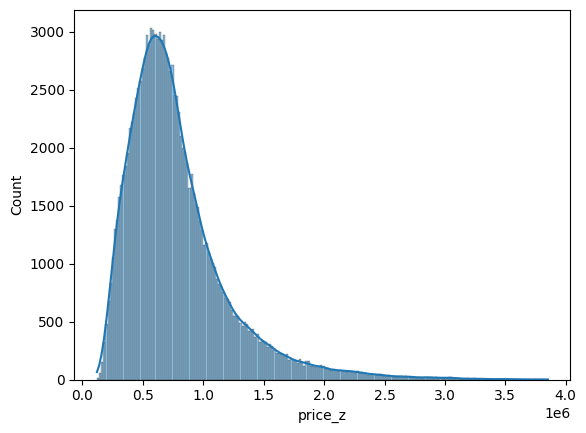

In [177]:
sns.histplot(df_train.price_z, kde=True)

<Axes: xlabel='price_z', ylabel='Count'>

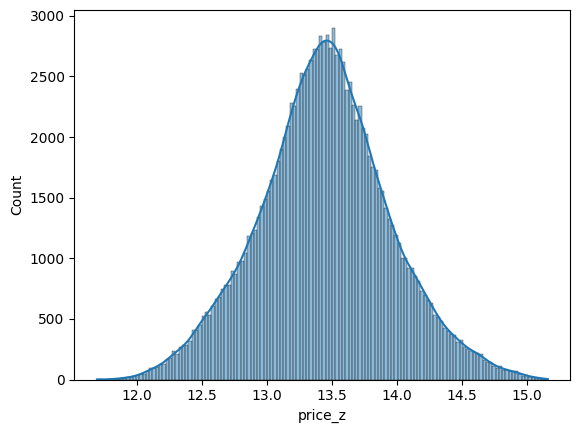

In [179]:
price_z_log = np.log(df_train.price_z + 1)
sns.histplot(price_z_log, kde=True)

## Feature Selection

In [184]:
numerical_variables

Index(['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built',
       'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post',
       'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'price_z',
       'market_volatility', 'infrastructure_quality',
       'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio',
       'estimated_maintenance_cost', 'global_economic_index'],
      dtype='object')

In [186]:
'''
Mutually correlated (irrelevant) variables
We can calculate correlations between numeric variables to identify redundant 
features (not always necessary - some methods are robust to the problem of 
multicollinearity)
'''

'\nMutually correlated (irrelevant) variables\nWe can calculate correlations between numeric variables to identify redundant \nfeatures (not always necessary - some methods are robust to the problem of \nmulticollinearity)\n'

In [188]:
train_numeric_correlations = df_train[numerical_variables].corr(method='pearson')

In [190]:
train_numeric_correlations

,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,dist_post,...,dist_uni,dist_pharma,price_z,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
dim_m2,1.000000,0.763315,-0.031711,-0.121481,-0.017163,0.042537,0.033081,0.062618,0.012848,0.053386,...,0.031329,0.054454,0.561631,0.546494,0.019365,-0.000540,0.001525,-0.039185,0.692064,-0.018613
n_rooms,0.763315,1.000000,-0.008416,-0.076762,0.000515,0.050624,0.003567,0.066284,0.037001,0.059298,...,0.044804,0.061766,0.472164,0.458800,0.003094,-0.000382,-0.000444,-0.043823,0.527586,-0.013422
floor_no,-0.031711,-0.008416,1.000000,0.602681,0.047493,-0.038464,0.051076,-0.097236,-0.120534,-0.075338,...,-0.061090,-0.097401,0.040283,0.039862,-0.042634,-0.002400,-0.000028,0.022600,-0.021681,0.010564
floor_max,-0.121481,-0.076762,0.602681,1.000000,0.113284,-0.038160,0.041347,-0.138220,-0.174009,-0.104344,...,-0.074735,-0.135234,0.033206,0.032871,-0.103100,0.000684,-0.002758,0.018373,-0.085468,0.013749
year_built,-0.017163,0.000515,0.047493,0.113284,1.000000,0.317382,-0.336712,0.235891,0.226440,0.212056,...,0.312366,0.179730,0.105871,0.102482,-0.918675,0.000091,-0.002700,-0.269987,-0.011948,0.001958
dist_centre,0.042537,0.050624,-0.038464,-0.038160,0.317382,1.000000,-0.445268,0.278545,0.409324,0.250915,...,0.491999,0.241907,0.081847,0.079934,-0.286997,-0.002293,0.002459,-0.826267,0.031395,0.010575
n_poi,0.033081,0.003567,0.051076,0.041347,-0.336712,-0.445268,1.000000,-0.301550,-0.361136,-0.315894,...,-0.424450,-0.295065,0.176504,0.171276,0.308818,-0.000054,-0.001438,0.308762,0.020824,-0.003935
dist_sch,0.062618,0.066284,-0.097236,-0.138220,0.235891,0.278545,-0.301550,1.000000,0.543627,0.737467,...,0.327756,0.781748,-0.000793,-0.000467,-0.214555,-0.000504,-0.000579,-0.273349,0.043695,-0.000134
dist_clinic,0.012848,0.037001,-0.120534,-0.174009,0.226440,0.409324,-0.361136,0.543627,1.000000,0.480390,...,0.425409,0.497598,-0.102731,-0.100249,-0.206841,0.000680,-0.000032,-0.375126,0.011458,0.005639
dist_post,0.053386,0.059298,-0.075338,-0.104344,0.212056,0.250915,-0.315894,0.737467,0.480390,1.000000,...,0.249145,0.783693,-0.011702,-0.011396,-0.193096,0.002520,-0.003252,-0.227702,0.036073,-0.003422


<Axes: >

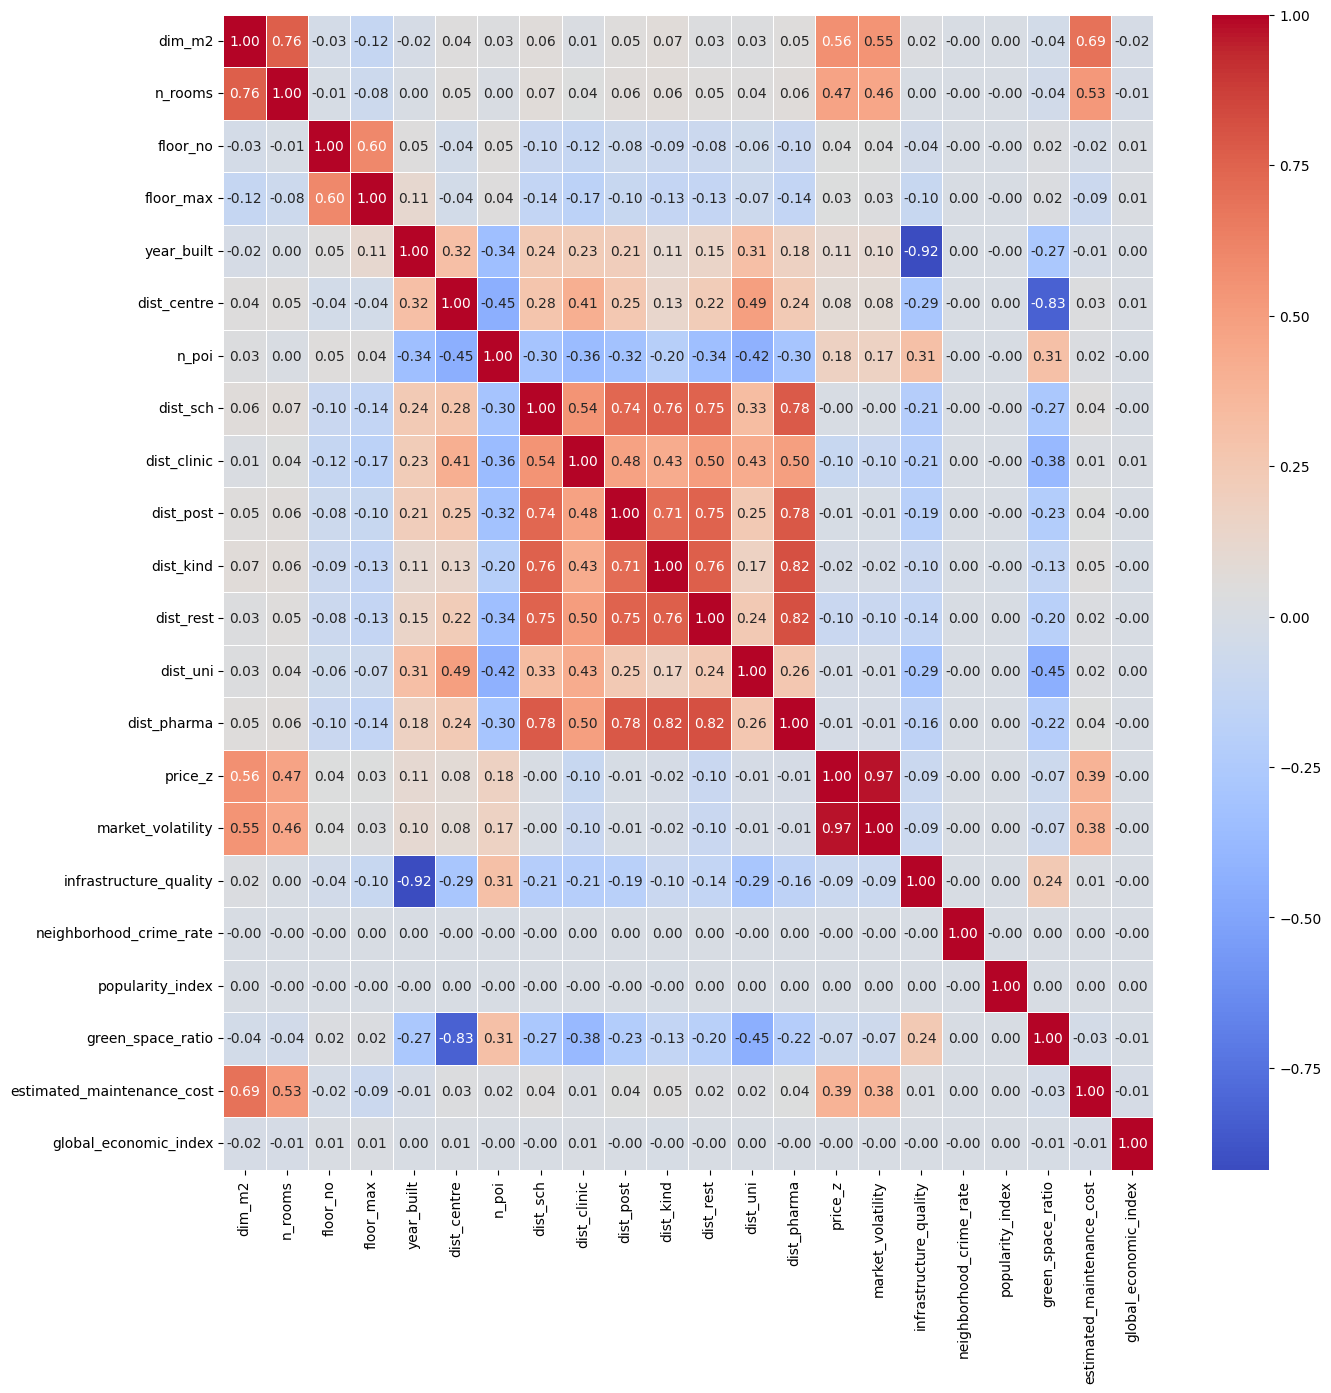

In [194]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_numeric_correlations,
            annot = True, 
            cmap = 'coolwarm', 
            fmt = '.2f',
            linewidths = 0.5)

In [196]:
mask = np.triu(np.ones_like(train_numeric_correlations, dtype=bool))
correlation_with_price_z = train_numeric_correlations.price_z.sort_values(ascending=False)
ordered_columns = correlation_with_price_z.index
train_numeric_correlations=train_numeric_correlations[ordered_columns].loc[ordered_columns]

<Axes: >

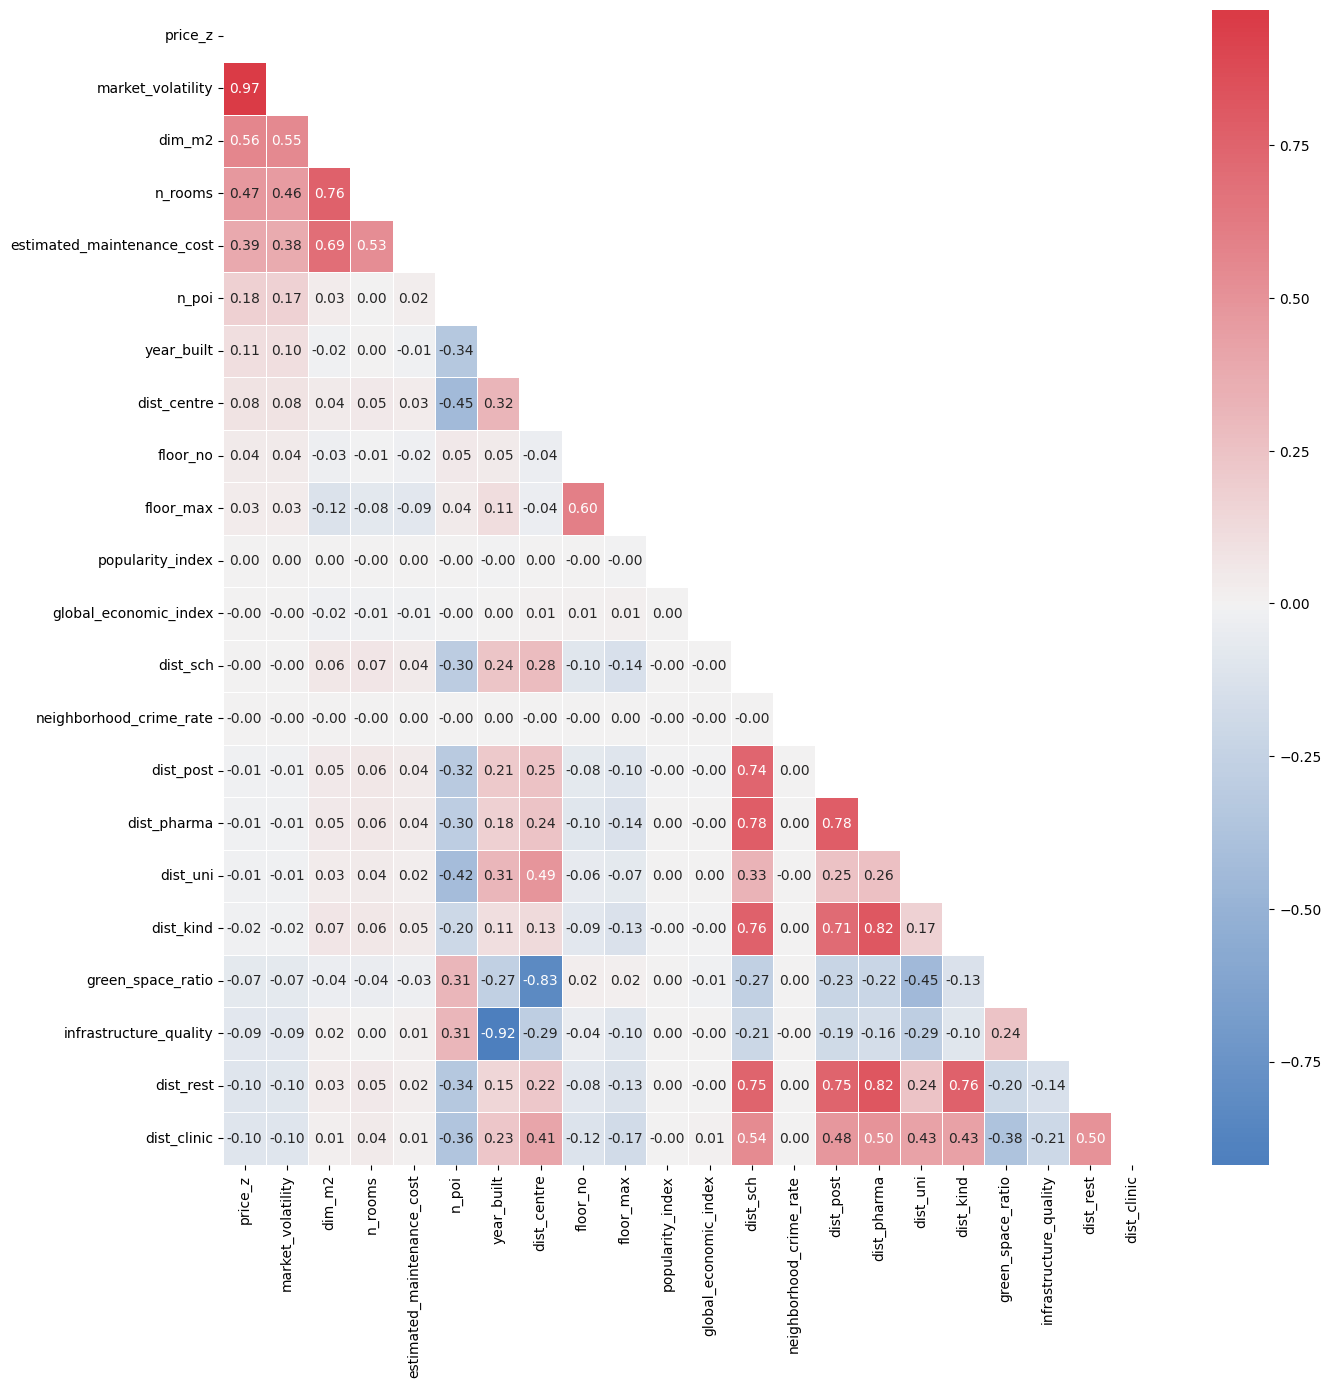

In [198]:
my_cmap = sns.diverging_palette(250, 10, as_cmap = True)
plt.figure(figsize=(15, 15))
sns.heatmap(train_numeric_correlations,
           annot = True,
           cmap = my_cmap,
           mask = mask,
           fmt = '.2f',
           linewidths = 0.5,
           # this argument ensures that the color map is centered at 0, 
           # meaning 0 will be displayed in white
           center = 0)

<Axes: >

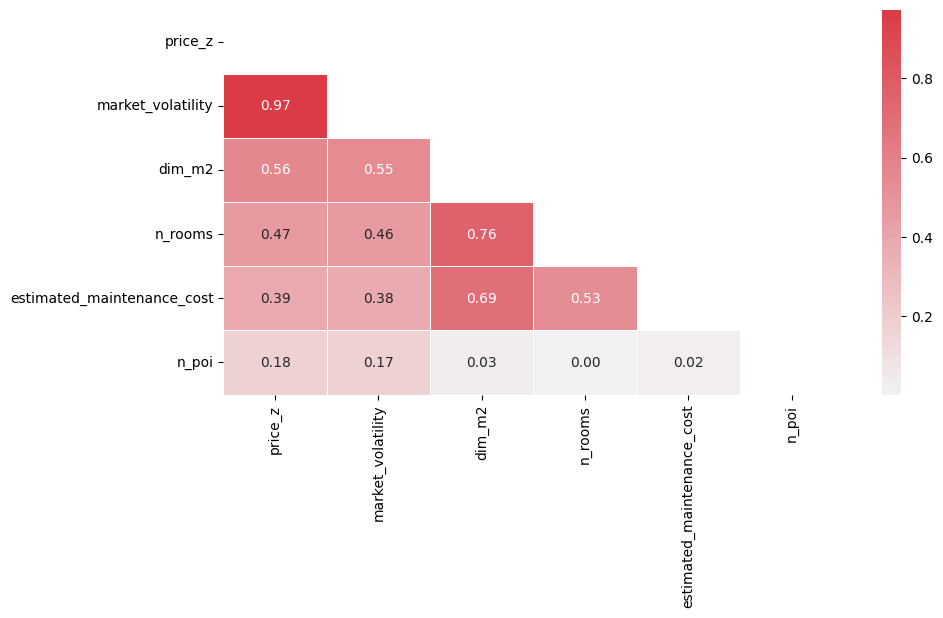

In [214]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_numeric_correlations.iloc[:6, :6],
            annot = True,
            cmap = my_cmap,
            mask = mask[:6, :6],
            fmt = '.2f',
            linewidths = 0.5,
            center = 0)

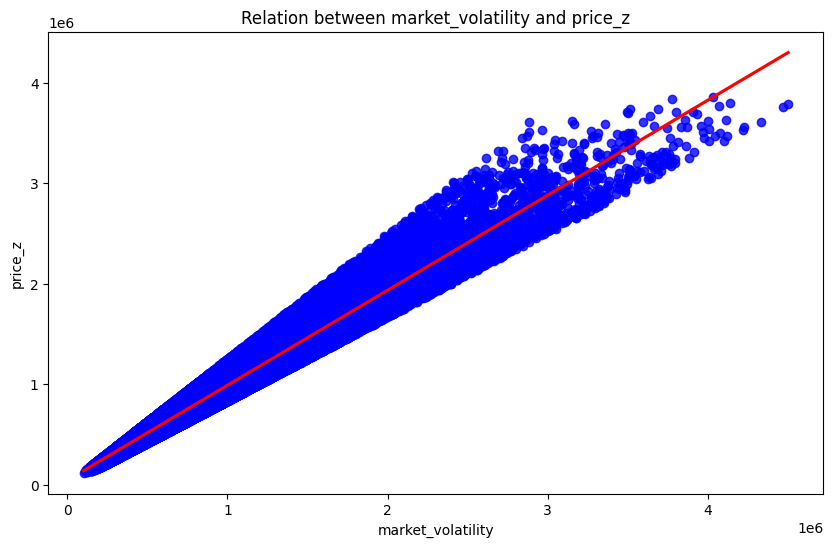

In [218]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'market_volatility', 
            y = 'price_z',
            data = df_train,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between market_volatility and price_z')
plt.xlabel('market_volatility')
plt.ylabel('price_z')
plt.show()

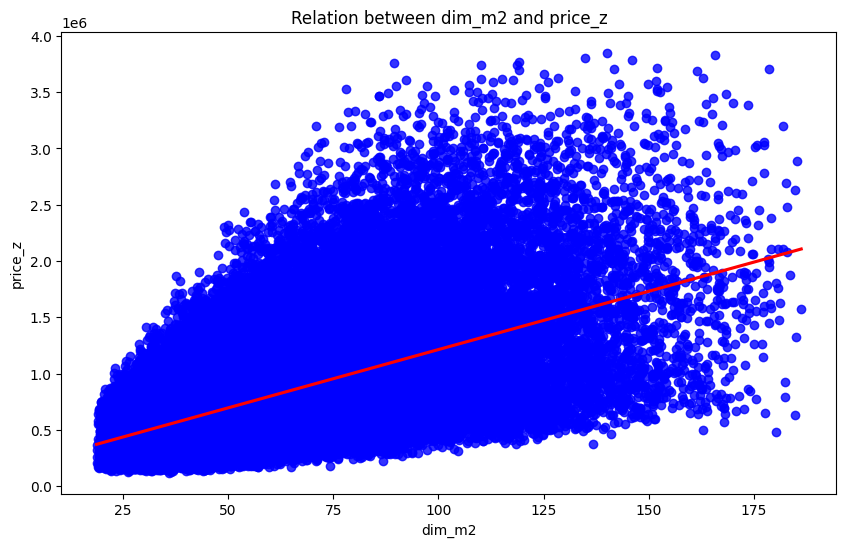

In [232]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'dim_m2', 
            y = 'price_z',
            data = df_train,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between dim_m2 and price_z')
plt.xlabel('dim_m2')
plt.ylabel('price_z')
plt.show()

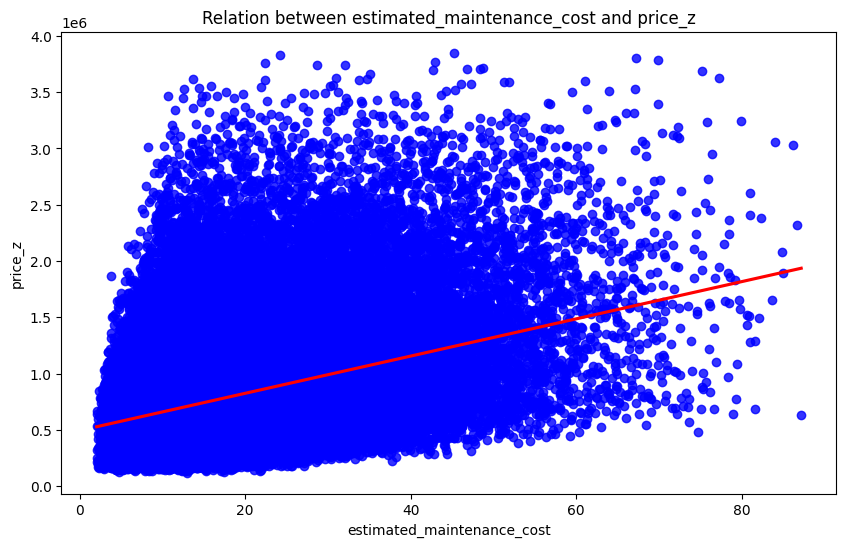

In [238]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'estimated_maintenance_cost', 
            y = 'price_z',
            data = df_train,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between estimated_maintenance_cost and price_z')
plt.xlabel('estimated_maintenance_cost')
plt.ylabel('price_z')
plt.show()

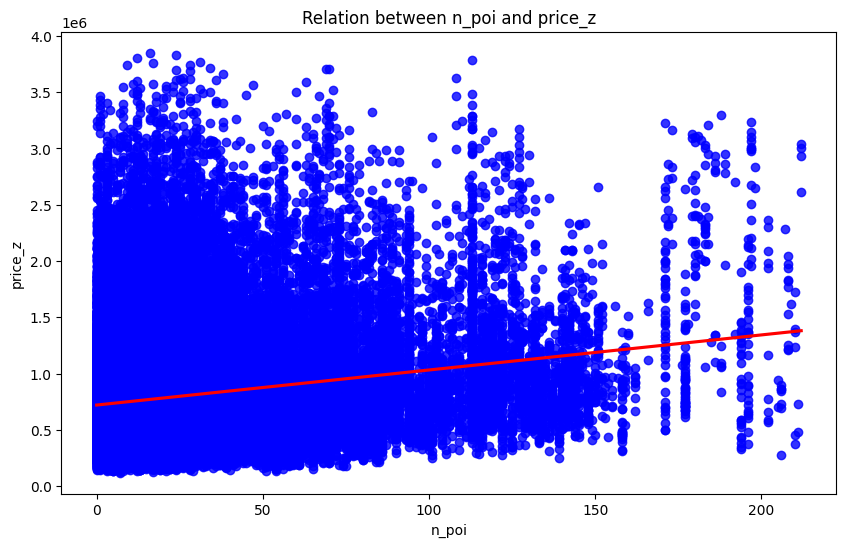

In [242]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'n_poi', 
            y = 'price_z',
            data = df_train,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between n_poi and price_z')
plt.xlabel('n_poi')
plt.ylabel('price_z')
plt.show()

In [294]:
'''
added: + dist_centre
others cannot be added because they had a lot of NaNs
'''

'\nadded: infrastructure_quality + dist_centre\nothers cannot be added because they had a lot of NaNs\n'

In [364]:
simple_model = smf.ols('price_z ~ market_volatility + dim_m2 + n_rooms + n_poi + dist_centre', 
                      data = df_train).fit()

In [372]:
print(simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:                price_z   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 4.492e+05
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        04:19:08   Log-Likelihood:            -1.6167e+06
No. Observations:              125163   AIC:                         3.233e+06
Df Residuals:                  125157   BIC:                         3.233e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3383.7768   1046.73

In [446]:
X = df_train[['market_volatility', 'dim_m2', 'n_rooms', 'n_poi','dist_centre']]
y = df_train['price_z']

In [448]:
df_model1 = LinearRegression()

In [450]:
df_model1.fit(X, y)

LinearRegression()

In [12]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [452]:
y_pred = df_model1.predict(X)
# y_pred = simple_model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
medae = median_absolute_error(y, y_pred)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Median Absolute Error:', medae)

Mean Absolute Error: 74388.15361266442
Root Mean Squared Error: 98474.4220843125
Median Absolute Error: 60257.27531038469


In [326]:
df_train.price_z.describe()

count    1.251630e+05
mean     7.841834e+05
std      4.286315e+05
min      1.196369e+05
25%      5.026919e+05
50%      6.902146e+05
75%      9.445603e+05
max      3.851902e+06
Name: price_z, dtype: float64

In [358]:
numerical_variables

Index(['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built',
       'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post',
       'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'price_z',
       'market_volatility', 'infrastructure_quality',
       'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio',
       'estimated_maintenance_cost', 'global_economic_index'],
      dtype='object')

In [360]:
categorical_variables

Index(['obj_type', 'own_type', 'build_mat', 'cond_class', 'has_park',
       'has_balcony', 'has_lift', 'has_sec', 'has_store', 'src_month'],
      dtype='object')

In [412]:
'''
obj_type, build_mat, cond_class - they contained missings
build_mat and cond_class can be dropped
'''

'\nobj_type, build_mat, cond_class - they contained missings\nbuild_mat and cond_class can be dropped\n'

In [384]:
model = smf.ols('price_z ~ C(has_park)', data = df_train).fit()

In [392]:
anova_table = anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(has_park),1.0,4.028000e+14,4.028000e+14,2231.477909,0.0
Residual,125161.0,2.259258e+16,1.805082e+11,NaN,NaN


In [ ]:
# The F statistic is used to verify the null hypothesis that:
# H0: Park does NOT impact the Price
# Our Result shows that having park affects the price of an appartment
# The higher the F-statistic (or the lower its p-value) the stronger we reject H0

In [14]:
def anova_for_categorical_vars(dataset, dependent_var, categorical_vars):
    results = []
    for var in categorical_vars:
        model = smf.ols(f'{dependent_var} ~ C({var})', data = dataset).fit()
        anova_table = anova_lm(model)
        f_statistic = anova_table['F'].iloc[0]
        p_value = anova_table['PR(>F)'].iloc[0]
        results.append([var, f_statistic, p_value])
        
    anova_results_df = pd.DataFrame(results,
                                   columns = ['Variable', 'F-statistic', 'p-values'])
    anova_results_df = anova_results_df.sort_values(by = 'F-statistic', ascending = False)
    
    return anova_results_df

In [398]:
df_anova_results = anova_for_categorical_vars(df_train,
                                                  'price_z',
                                                  categorical_variables)

In [400]:
print(df_anova_results)

      Variable  F-statistic       p-values
6     has_lift  4438.392949   0.000000e+00
0     obj_type  3954.727758   0.000000e+00
2    build_mat  3746.273888   0.000000e+00
8    has_store  3321.287730   0.000000e+00
7      has_sec  2362.623929   0.000000e+00
4     has_park  2231.477909   0.000000e+00
3   cond_class  1054.065253   0.000000e+00
1     own_type   725.174348  7.439744e-314
5  has_balcony   592.833589  1.223225e-130
9    src_month   190.445920   0.000000e+00


In [410]:
df_anova_results.head()

,Variable,F-statistic,p-values
6,has_lift,4438.392949,0.0
0,obj_type,3954.727758,0.0
2,build_mat,3746.273888,0.0
8,has_store,3321.287730,0.0
7,has_sec,2362.623929,0.0


In [428]:
df_train.drop(['build_mat', 'cond_class'], axis=1, inplace=True)
df_test.drop(['build_mat', 'cond_class'], axis=1, inplace=True)

In [432]:
'''
floor_no 27% 
year_built 25%
dist_sch based 00 corr
dist_clinic 15%
dist_post based 00 corr
dist_kind based 00 corr
dist_rest based on -10
dist_uni 43%
dist_pharma based 00
infrastructure_quality 25%
'''

'\nfloor_no 27% \nyear_built 25%\ndist_sch based 00 corr\ndist_clinic 15%\ndist_post based 00 corr\ndist_kind based 00 corr\ndist_rest based on -10\ndist_uni 43%\ndist_pharma based 00\ninfrastructure_quality 25%\n'

In [436]:
# based on missing values, need to drop some variables
columns_to_drop = ['floor_no', 'year_built', 'dist_clinic',
                   'dist_uni', 'infrastructure_quality']
columns_to_reconsider = ['dist_sch', 'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma']

In [462]:
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)

In [464]:
categorical_variables = df_train.select_dtypes('object').columns
numerical_variables = df_train.select_dtypes(include=[np.number]).columns

In [466]:
categorical_variables

Index(['obj_type', 'own_type', 'has_park', 'has_balcony', 'has_lift',
       'has_sec', 'has_store', 'src_month'],
      dtype='object')

In [468]:
numerical_variables

Index(['dim_m2', 'n_rooms', 'floor_max', 'dist_centre', 'n_poi', 'dist_sch',
       'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma', 'price_z',
       'market_volatility', 'neighborhood_crime_rate', 'popularity_index',
       'green_space_ratio', 'estimated_maintenance_cost',
       'global_economic_index'],
      dtype='object')

In [474]:
train_numeric_correlations = df_train[numerical_variables].corr(method='pearson')

In [478]:
mask = np.triu(np.ones_like(train_numeric_correlations, dtype=bool))
correlation_with_price_z = train_numeric_correlations.price_z.sort_values(ascending=False)
ordered_columns = correlation_with_price_z.index
train_numeric_correlations=train_numeric_correlations[ordered_columns].loc[ordered_columns]

<Axes: >

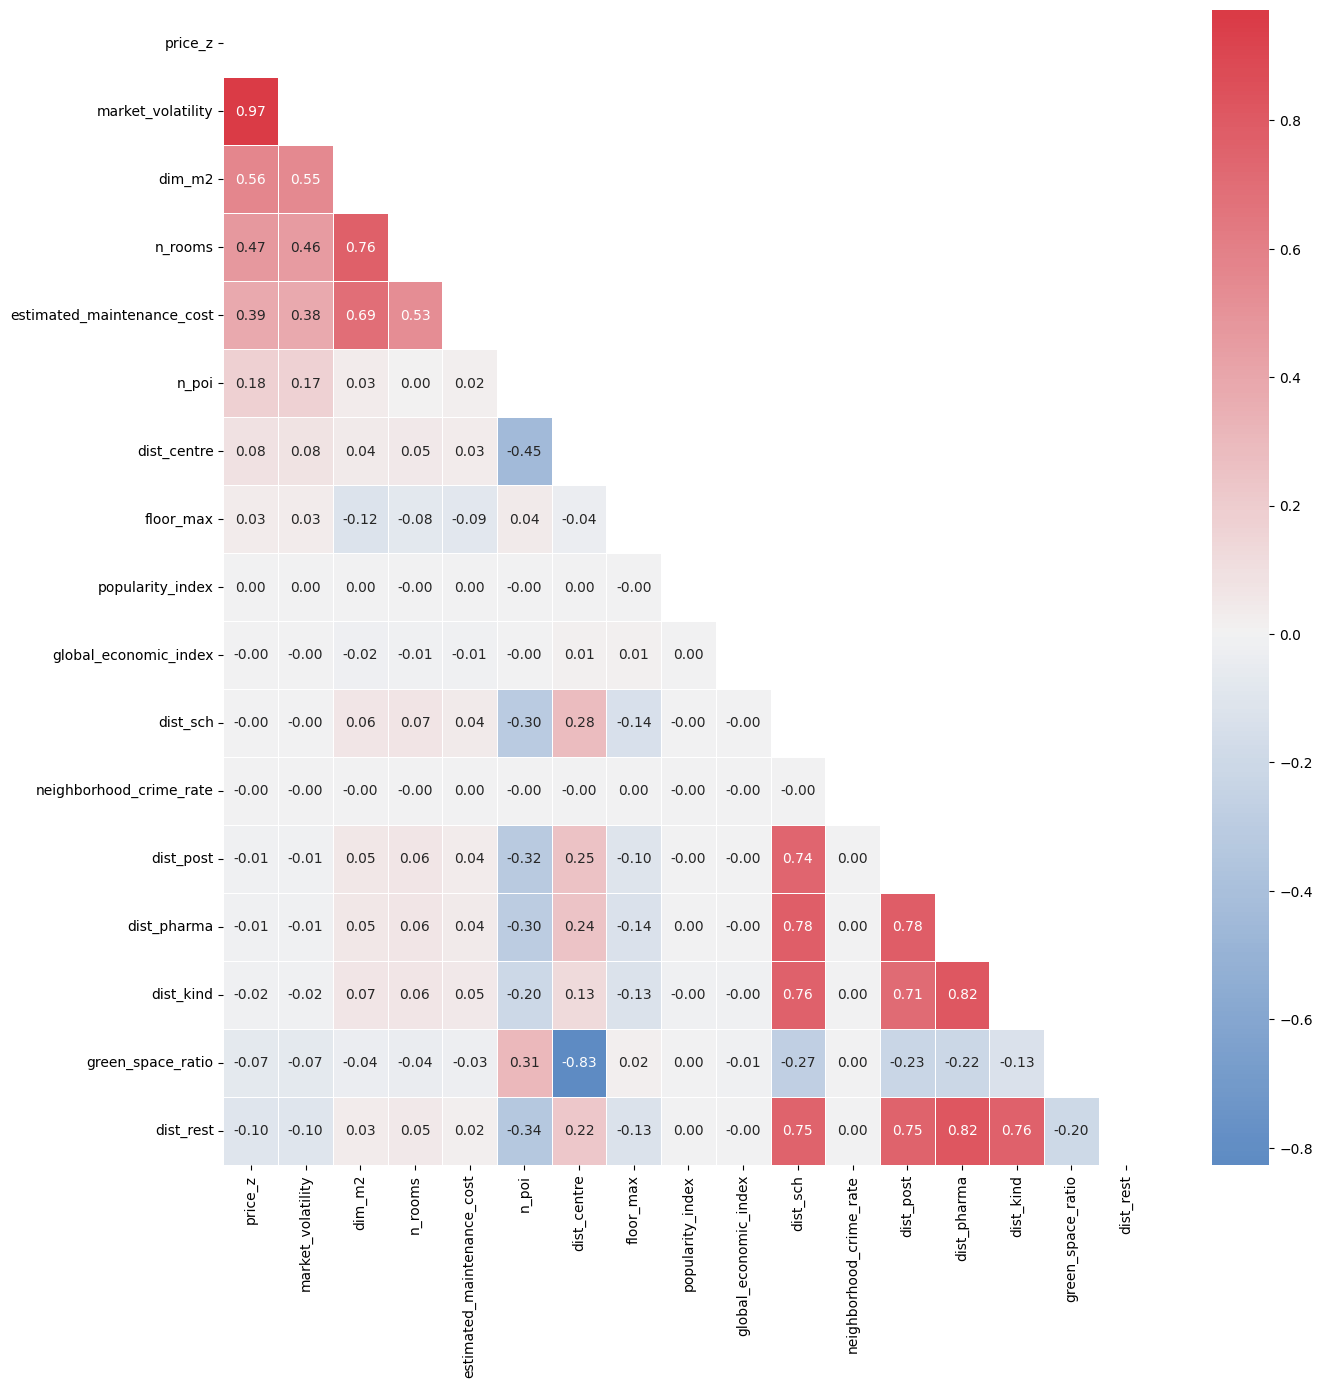

In [480]:
my_cmap = sns.diverging_palette(250, 10, as_cmap = True)
plt.figure(figsize=(15, 15))
sns.heatmap(train_numeric_correlations,
           annot = True,
           cmap = my_cmap,
           mask = mask,
           fmt = '.2f',
           linewidths = 0.5,
           # this argument ensures that the color map is centered at 0, 
           # meaning 0 will be displayed in white
           center = 0)

In [482]:
df_anova_results = anova_for_categorical_vars(df_train,
                                                  'price_z',
                                                  categorical_variables)

In [484]:
print(df_anova_results)

      Variable  F-statistic       p-values
4     has_lift  4438.392949   0.000000e+00
0     obj_type  3954.727758   0.000000e+00
6    has_store  3321.287730   0.000000e+00
5      has_sec  2362.623929   0.000000e+00
2     has_park  2231.477909   0.000000e+00
1     own_type   725.174348  7.439744e-314
3  has_balcony   592.833589  1.223225e-130
7    src_month   190.445920   0.000000e+00


In [486]:
'''
it is obvious that all categorical variables do impact the price
'''

'\nit is obvious that all categorical variables do impact the price\n'

In [488]:
X = df_train[['market_volatility', 'dim_m2', 'n_rooms', 'n_poi','dist_centre',
             'floor_max', 'green_space_ratio', 'dist_rest']]
y = df_train['price_z']

In [490]:
df_model1 = LinearRegression()

In [492]:
df_model1.fit(X, y)

LinearRegression()

In [498]:
y_pred = df_model1.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
medae = median_absolute_error(y, y_pred)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Median Absolute Error:', medae)

Mean Absolute Error: 74315.37737377755
Root Mean Squared Error: 98376.84252057933
Median Absolute Error: 60162.55239818379


In [496]:
# previous model results
# Mean Absolute Error: 74388.15361266442
# Root Mean Squared Error: 98474.4220843125
# Median Absolute Error: 60257.27531038469

In [506]:
for col in categorical_variables:
    print('--------------------------')
    print(df_train[col].value_counts())
    print('--------------------------')

--------------------------
obj_type
0d6c4dfc    58673
Unknown     26996
2a6d5c01    20662
0c238f18    18832
Name: count, dtype: int64
--------------------------
--------------------------
own_type
12631efb    112691
bfb8fe10     12464
Other            8
Name: count, dtype: int64
--------------------------
--------------------------
has_park
no     91178
yes    33985
Name: count, dtype: int64
--------------------------
--------------------------
has_balcony
yes    71599
no     53564
Name: count, dtype: int64
--------------------------
--------------------------
has_lift
no     63003
yes    62160
Name: count, dtype: int64
--------------------------
--------------------------
has_sec
no     111096
yes     14067
Name: count, dtype: int64
--------------------------
--------------------------
has_store
no     70749
yes    54414
Name: count, dtype: int64
--------------------------
--------------------------
src_month
2024-06    13768
2024-05    13034
2024-04    12344
2023-08    11949
2024-03 

In [510]:
# i dont have ordinal variables so treat categorical variables as normal

In [552]:
categorical_variables_with_3_levels = ['obj_type', 'own_type']
categorical_variables_with_2 = categorical_variables.to_list()
categorical_variables_with_2.remove('obj_type')
categorical_variables_with_2.remove('own_type')
print(categorical_variables_with_3_levels)
print(categorical_variables_with_2)

['obj_type', 'own_type']
['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store', 'src_month']


In [562]:
encoded_train = df_train.copy()
encoded_test = df_test.copy()

In [556]:
encoded_train.head()

,obj_type,dim_m2,n_rooms,floor_max,dist_centre,n_poi,dist_sch,dist_post,dist_kind,dist_rest,...,has_sec,has_store,price_z,src_month,market_volatility,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
96871,0d6c4dfc,66.99,3.0,10.0,5.507,16.0,0.565,0.250,0.469,0.226,...,yes,no,1185268.46,2024-01,1343939.66,43.37,61.90,0.999,19.23,93.407843
85950,2a6d5c01,54.58,2.0,3.0,3.971,13.0,0.168,0.471,0.188,0.096,...,no,no,1204326.79,2024-06,1029030.60,86.49,43.49,1.000,14.26,107.920758
117011,0d6c4dfc,65.52,2.0,4.0,3.908,21.0,0.205,0.243,0.062,0.289,...,no,yes,391741.03,2023-11,421432.28,93.77,51.10,1.000,7.32,95.619755
3997,0d6c4dfc,57.81,3.0,11.0,4.831,8.0,0.230,0.924,0.392,0.448,...,no,no,313997.02,2023-12,342176.37,11.95,59.00,1.000,22.96,94.500955
66009,0d6c4dfc,36.24,2.0,4.0,1.077,48.0,0.079,0.162,0.075,0.192,...,no,yes,463618.30,2023-08,430504.37,62.56,56.15,1.000,17.91,106.368140


In [564]:
# train - 2 levels
encoded_train = pd.get_dummies(encoded_train,
                               columns = categorical_variables_with_2,
                               drop_first = True,
                               dtype = int
                               )
# test - 2 levels
encoded_test = pd.get_dummies(encoded_test,
                              columns = categorical_variables_with_2,
                              drop_first = True,
                              dtype = int
                              )

# train - >3 levels
encoded_train = pd.get_dummies(encoded_train,
                               columns = categorical_variables_with_3_levels,
                               drop_first = False,
                               dtype = int
                               )
# test - >3 levels
encoded_test = pd.get_dummies(encoded_test,
                              columns = categorical_variables_with_3_levels,
                              drop_first = False,
                              dtype = int
                              )

In [566]:
encoded_train.head()

,dim_m2,n_rooms,floor_max,dist_centre,n_poi,dist_sch,dist_post,dist_kind,dist_rest,dist_pharma,...,src_month_2024-04,src_month_2024-05,src_month_2024-06,obj_type_0c238f18,obj_type_0d6c4dfc,obj_type_2a6d5c01,obj_type_Unknown,own_type_12631efb,own_type_Other,own_type_bfb8fe10
96871,66.99,3.0,10.0,5.507,16.0,0.565,0.250,0.469,0.226,0.188,...,0,0,0,0,1,0,0,1,0,0
85950,54.58,2.0,3.0,3.971,13.0,0.168,0.471,0.188,0.096,0.288,...,0,0,1,0,0,1,0,1,0,0
117011,65.52,2.0,4.0,3.908,21.0,0.205,0.243,0.062,0.289,0.252,...,0,0,0,0,1,0,0,0,0,1
3997,57.81,3.0,11.0,4.831,8.0,0.230,0.924,0.392,0.448,0.051,...,0,0,0,0,1,0,0,1,0,0
66009,36.24,2.0,4.0,1.077,48.0,0.079,0.162,0.075,0.192,0.207,...,0,0,0,0,1,0,0,1,0,0


In [568]:
encoded_test.head()

,dim_m2,n_rooms,floor_max,dist_centre,n_poi,dist_sch,dist_post,dist_kind,dist_rest,dist_pharma,...,src_month_2024-04,src_month_2024-05,src_month_2024-06,obj_type_0c238f18,obj_type_0d6c4dfc,obj_type_2a6d5c01,obj_type_Unknown,own_type_12631efb,own_type_Other,own_type_bfb8fe10
62171,67.62,3.0,4.0,4.554,23.0,0.096,0.416,0.131,0.287,0.295,...,1,0,0,0,1,0,0,0,0,1
12494,83.31,5.0,4.0,1.356,38.0,0.057,0.420,0.072,0.371,0.208,...,0,0,0,1,0,0,0,1,0,0
21885,26.94,2.0,8.0,2.640,16.0,0.373,0.699,0.193,0.209,0.295,...,0,0,0,0,0,1,0,1,0,0
142343,63.33,3.0,4.0,0.409,29.0,0.366,0.240,0.070,0.214,0.185,...,0,0,0,0,0,0,1,1,0,0
63316,53.04,2.0,4.0,2.247,22.0,0.156,0.328,0.101,0.132,0.192,...,0,0,0,0,1,0,0,1,0,0


In [570]:
encoded_train.columns.tolist()

['dim_m2',
 'n_rooms',
 'floor_max',
 'dist_centre',
 'n_poi',
 'dist_sch',
 'dist_post',
 'dist_kind',
 'dist_rest',
 'dist_pharma',
 'price_z',
 'market_volatility',
 'neighborhood_crime_rate',
 'popularity_index',
 'green_space_ratio',
 'estimated_maintenance_cost',
 'global_economic_index',
 'has_park_yes',
 'has_balcony_yes',
 'has_lift_yes',
 'has_sec_yes',
 'has_store_yes',
 'src_month_2023-09',
 'src_month_2023-10',
 'src_month_2023-11',
 'src_month_2023-12',
 'src_month_2024-01',
 'src_month_2024-02',
 'src_month_2024-03',
 'src_month_2024-04',
 'src_month_2024-05',
 'src_month_2024-06',
 'obj_type_0c238f18',
 'obj_type_0d6c4dfc',
 'obj_type_2a6d5c01',
 'obj_type_Unknown',
 'own_type_12631efb',
 'own_type_Other',
 'own_type_bfb8fe10']

In [574]:
temp_categorical_variables = encoded_train.select_dtypes('object').columns
temp_categorical_variables

Index([], dtype='object')

In [582]:
print(encoded_train.select_dtypes(include='object').head())

Empty DataFrame
Columns: []
Index: [96871, 85950, 117011, 3997, 66009]


In [588]:
encoded_train = encoded_train.apply(pd.to_numeric)
encoded_test = encoded_test.apply(pd.to_numeric)

In [590]:
print(encoded_train.select_dtypes(include='object').head())

Empty DataFrame
Columns: []
Index: [96871, 85950, 117011, 3997, 66009]


In [616]:
X = encoded_train[
    [
        'market_volatility', 'dim_m2', 'n_rooms', 'n_poi', 'dist_centre',
        'floor_max', 'green_space_ratio', 'dist_rest', 'has_park_yes', 'has_balcony_yes',
        'has_lift_yes', 'has_sec_yes', 'has_store_yes', 'src_month_2023-09', 
        'src_month_2023-10','src_month_2023-11', 'src_month_2023-12', 'src_month_2024-01', 
        'src_month_2024-02',
        'src_month_2024-03', 'src_month_2024-04', 'src_month_2024-05', 'src_month_2024-06',
        'obj_type_0c238f18', 'obj_type_0d6c4dfc', 'obj_type_2a6d5c01', 'obj_type_Unknown',
        'own_type_12631efb', 'own_type_Other', 'own_type_bfb8fe10'
    ]
]

y = encoded_train['price_z']

In [618]:
df_model1 = LinearRegression()

In [620]:
df_model1.fit(X, y)

LinearRegression()

In [622]:
y_pred = df_model1.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
medae = median_absolute_error(y, y_pred)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Median Absolute Error:', medae)

Mean Absolute Error: 73597.04545470077
Root Mean Squared Error: 97627.39937017746
Median Absolute Error: 59171.45048879157


In [604]:
# previous model results
# Mean Absolute Error: 74388.15361266442
# Root Mean Squared Error: 98474.4220843125
# Median Absolute Error: 60257.27531038469

In [626]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                price_z   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                 8.168e+04
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        05:40:23   Log-Likelihood:            -1.6156e+06
No. Observations:              125163   AIC:                         3.231e+06
Df Residuals:                  125134   BIC:                         3.232e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.978e+06   6.41e+0

In [628]:
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
medae = median_absolute_error(y, y_pred)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Median Absolute Error:', medae)

Mean Absolute Error: 73597.04545424477
Root Mean Squared Error: 97627.39937017746
Median Absolute Error: 59171.45124587719


In [634]:
X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 
                                      'dist_kind', 'dist_rest', 'dist_pharma'])
y_train = encoded_train['price_z']

In [636]:
X_test = encoded_test.drop(columns=['price_z', 'dist_sch', 'dist_post', 
                                      'dist_kind', 'dist_rest', 'dist_pharma'])
y_test = encoded_test['price_z']

In [16]:
from sklearn.linear_model import Ridge

In [662]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)

Ridge(alpha=1)

In [664]:
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

In [666]:
# Evaluate
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MedAE:", median_absolute_error(y_train, y_train_pred))
print("Test MedAE:", median_absolute_error(y_test, y_test_pred))

Train RMSE: 97685.05560707703
Test RMSE: 98942.81678620585
Train MAE: 73631.229903564
Test MAE: 74207.2872262031
Train MedAE: 59218.97462550795
Test MedAE: 59348.85278517811


In [672]:
'''
This is moderate performance—errors aren’t tiny but not huge either.

Train and test errors are close → no obvious overfitting.
'''

'\nThis is moderate performance—errors aren’t tiny but not huge either.\n\nTrain and test errors are close → no obvious overfitting.\n'

In [678]:
encoded_train.price_z.describe()

count    1.251630e+05
mean     7.841834e+05
std      4.286315e+05
min      1.196369e+05
25%      5.026919e+05
50%      6.902146e+05
75%      9.445603e+05
max      3.851902e+06
Name: price_z, dtype: float64

In [680]:
mean_price = 784183.4 
rmse = 97627.4
mae = 73597.0

rmse_percent = (rmse / mean_price) * 100
mae_percent = (mae / mean_price) * 100

print(f"RMSE is {rmse_percent:.2f}% of mean price")
print(f"MAE is {mae_percent:.2f}% of mean price")


RMSE is 12.45% of mean price
MAE is 9.39% of mean price


In [18]:
from sklearn.linear_model import Lasso

In [686]:
X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 
                                      'dist_kind', 'dist_rest', 'dist_pharma'])
y_train = encoded_train['price_z']
#----------------------------Train - Test -------------------------------------------
X_test = encoded_test.drop(columns=['price_z', 'dist_sch', 'dist_post', 
                                      'dist_kind', 'dist_rest', 'dist_pharma'])
y_test = encoded_test['price_z']

lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MedAE:", median_absolute_error(y_train, y_train_pred))
print("Test MedAE:", median_absolute_error(y_test, y_test_pred))

Train RMSE: 97685.23679229412
Test RMSE: 98941.27053999239
Train MAE: 73631.29252910415
Test MAE: 74205.4540201435
Train MedAE: 59202.06431163929
Test MedAE: 59339.25505814236


In [690]:
r2_train = ridge_model.score(X_train, y_train)
r2_test = ridge_model.score(X_test, y_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)

Train R²: 0.9480612372766903
Test R²: 0.9485576488998464


In [692]:
r2_train = lasso_model.score(X_train, y_train)
r2_test = lasso_model.score(X_test, y_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)

Train R²: 0.9480610446055664
Test R²: 0.9485592567360016


In [4]:
import pickle

In [706]:
# Save dataframes
with open('df_train.pkl', 'wb') as f:
    pickle.dump(df_train, f)
with open('encoded_train.pkl', 'wb') as f:
    pickle.dump(encoded_train, f)
with open('df_test.pkl', 'wb') as f:
    pickle.dump(df_test, f)
with open('encoded_test.pkl', 'wb') as f:
    pickle.dump(encoded_test, f)

# Save models
with open('ridge_model.pkl', 'wb') as f:
    pickle.dump(ridge_model, f)
with open('lasso_model.pkl', 'wb') as f:
    pickle.dump(lasso_model, f)
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [743]:
# # Load dataframes
# with open('df_train.pkl', 'rb') as f:
#     df_train = pickle.load(f)
# with open('encoded_train.pkl', 'rb') as f:
#     encoded_train = pickle.load(f)
# with open('df_test.pkl', 'rb') as f:
#     df_test = pickle.load(f)
# with open('encoded_test.pkl', 'rb') as f:
#     encoded_test = pickle.load(f)

# # Load models
# with open('ridge_model.pkl', 'rb') as f:
#     ridge_model = pickle.load(f)
# with open('lasso_model.pkl', 'rb') as f:
#     lasso_model = pickle.load(f)
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [20]:
import xgboost as xgb

In [712]:
X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post',                                      'dist_kind', 'dist_rest', 'dist_pharma'])
y_train = encoded_train['price_z']
X_test = encoded_test.drop(columns=['price_z', 'dist_sch', 'dist_post', 
                                   'dist_kind', 'dist_rest', 'dist_pharma'])
y_test = encoded_test['price_z']

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MedAE:", median_absolute_error(y_train, y_train_pred))
print("Test MedAE:", median_absolute_error(y_test, y_test_pred))

Train RMSE: 91904.07799418127
Test RMSE: 98882.7729988645
Train MAE: 70000.43489389335
Test MAE: 73262.43458464496
Train MedAE: 56639.560624999984
Test MedAE: 58246.327500000014


In [22]:
from sklearn.ensemble import RandomForestRegressor

In [716]:
X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma'])
y_train = encoded_train['price_z']

X_test = encoded_test.drop(columns=['price_z', 'dist_sch', 'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma'])
y_test = encoded_test['price_z']

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,      
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MedAE:", median_absolute_error(y_train, y_train_pred))
print("Test MedAE:", median_absolute_error(y_test, y_test_pred))

Train RMSE: 89745.66503355025
Test RMSE: 98473.90034457695
Train MAE: 69321.90972784083
Test MAE: 73980.36629792277
Train MedAE: 57271.58916428569
Test MedAE: 59397.0423429099


In [24]:
import lightgbm as lgb

In [728]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MedAE:", median_absolute_error(y_train, y_train_pred))
print("Test MedAE:", median_absolute_error(y_test, y_test_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 125163, number of used features: 32
[LightGBM] [Info] Start training from score 784183.422197
Train RMSE: 93174.11763142124
Test RMSE: 98672.73927408988
Train MAE: 71023.13440138043
Test MAE: 73361.96409677893
Train MedAE: 57828.866568732075
Test MedAE: 58511.16945957963


In [26]:
from sklearn.linear_model import ElasticNet

In [732]:
en_model = ElasticNet(
    alpha=1.0,
    l1_ratio=0.5,
    random_state=42,
    max_iter=10000
)

en_model.fit(X_train, y_train)

y_train_pred = en_model.predict(X_train)
y_test_pred = en_model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MedAE:", median_absolute_error(y_train, y_train_pred))
print("Test MedAE:", median_absolute_error(y_test, y_test_pred))

Train RMSE: 98049.38863074231
Test RMSE: 99315.29495328359
Train MAE: 74016.34938794923
Test MAE: 74503.17664862431
Train MedAE: 59853.1024944465
Test MedAE: 59657.243394444115


In [28]:
from catboost import CatBoostRegressor

In [741]:
cat_model = CatBoostRegressor(
    iterations=100,
    depth=10,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train, y_train)

y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train MedAE:", median_absolute_error(y_train, y_train_pred))
print("Test MedAE:", median_absolute_error(y_test, y_test_pred))

Train RMSE: 93510.52193602921
Test RMSE: 98981.8161232145
Train MAE: 71158.13809223987
Test MAE: 73517.34276924863
Train MedAE: 57651.462926285516
Test MedAE: 58475.37566008663


In [745]:
# Save models
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)
with open('en_model.pkl', 'wb') as f:
    pickle.dump(en_model, f)
with open('cat_model.pkl', 'wb') as f:
    pickle.dump(cat_model, f)

In [ ]:
# # Load models
# with open('xgb_model.pkl', 'rb') as f:
#     ridge_model = pickle.load(f)
# with open('rf_model.pkl', 'rb') as f:
#     lasso_model = pickle.load(f)
# with open('lgb_model.pkl', 'rb') as f:
#     model = pickle.load(f)
# with open('en_model.pkl', 'rb') as f:
#     model = pickle.load(f)
# with open('cat_model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [747]:
r2_train = xgb_model.score(X_train, y_train)
r2_test = xgb_model.score(X_test, y_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)

Train R²: 0.9540267815484658
Test R²: 0.9486200658891257


In [749]:
r2_train = rf_model.score(X_train, y_train)
r2_test = rf_model.score(X_test, y_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)

Train R²: 0.9561608319465048
Test R²: 0.9490440915607343


In [751]:
r2_train = lgb_model.score(X_train, y_train)
r2_test = lgb_model.score(X_test, y_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)

Train R²: 0.952747377043301
Test R²: 0.9488381030184158


In [753]:
r2_train = en_model.score(X_train, y_train)
r2_test = en_model.score(X_test, y_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)

Train R²: 0.9476730858929276
Test R²: 0.9481696021447761


In [755]:
r2_train = cat_model.score(X_train, y_train)
r2_test = cat_model.score(X_test, y_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)

Train R²: 0.9524055507437338
Test R²: 0.948517087835628


# Real Test Dataset

In [184]:
df_final_test = pd.read_csv('data/appartments_test.csv')

In [186]:
df_final_test.head()

,unit_id,obj_type,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,...,has_store,src_month,loc_code,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
0,553836e34a0d5d6b,0d6c4dfc,75.51,3.0,2.0,4.0,1997.0,4.690,10.0,0.070,...,yes,2023-08,143768f7,563934.93,15.52,74.32,34.58,1.0,32.09,105.344824
1,e04d0521349583d9,0c238f18,73.38,4.0,4.0,4.0,1930.0,2.297,13.0,0.323,...,no,2023-08,143768f7,629517.22,89.16,2.53,49.96,1.0,17.23,105.345748
2,83179d073b8319db,0c238f18,117.49,5.0,2.0,4.0,1936.0,1.019,39.0,0.250,...,yes,2023-08,143768f7,558287.39,129.36,69.03,49.51,1.0,25.56,105.540787
3,9af01b0ba6016d69,0d6c4dfc,39.61,2.0,6.0,10.0,1970.0,3.965,11.0,0.048,...,no,2023-08,143768f7,241548.94,50.81,38.39,27.78,1.0,19.19,104.588730
4,086cba055ca54004,0d6c4dfc,56.24,3.0,2.0,3.0,1970.0,4.880,11.0,0.248,...,yes,2023-08,143768f7,295729.62,38.10,25.11,56.67,1.0,9.11,105.139462


In [698]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39114 entries, 0 to 39113
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   unit_id                     39114 non-null  object 
 1   obj_type                    30673 non-null  object 
 2   dim_m2                      39114 non-null  float64
 3   n_rooms                     39114 non-null  float64
 4   floor_no                    32218 non-null  float64
 5   floor_max                   38652 non-null  float64
 6   year_built                  32611 non-null  float64
 7   dist_centre                 39114 non-null  float64
 8   n_poi                       39114 non-null  float64
 9   dist_sch                    39076 non-null  float64
 10  dist_clinic                 38957 non-null  float64
 11  dist_post                   39054 non-null  float64
 12  dist_kind                   39070 non-null  float64
 13  dist_rest                   390

In [700]:
encoded_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125163 entries, 96871 to 121958
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   dim_m2                      125163 non-null  float64
 1   n_rooms                     125163 non-null  float64
 2   floor_max                   125163 non-null  float64
 3   dist_centre                 125163 non-null  float64
 4   n_poi                       125163 non-null  float64
 5   dist_sch                    125163 non-null  float64
 6   dist_post                   125163 non-null  float64
 7   dist_kind                   125163 non-null  float64
 8   dist_rest                   125163 non-null  float64
 9   dist_pharma                 125163 non-null  float64
 10  price_z                     125163 non-null  float64
 11  market_volatility           125163 non-null  float64
 12  neighborhood_crime_rate     125163 non-null  float64
 13  popularity_inde

## Part 2

In [6]:
import pickle

In [188]:
# Load dataframes
with open('df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)
with open('encoded_train.pkl', 'rb') as f:
    encoded_train = pickle.load(f)
with open('df_test.pkl', 'rb') as f:
    df_test = pickle.load(f)
with open('encoded_test.pkl', 'rb') as f:
    encoded_test = pickle.load(f)

# Load models
with open('ridge_model.pkl', 'rb') as f:
    ridge_model = pickle.load(f)
with open('lasso_model.pkl', 'rb') as f:
    lasso_model = pickle.load(f)
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [196]:
# Load models
with open('xgb_model.pkl', 'rb') as f:
    ridge_model = pickle.load(f)
with open('rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)
with open('lgb_model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('en_model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('cat_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
# X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 
#                                       'dist_kind', 'dist_rest', 'dist_pharma'])

In [36]:
encoded_train.columns

Index(['dim_m2', 'n_rooms', 'floor_max', 'dist_centre', 'n_poi', 'dist_sch',
       'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma', 'price_z',
       'market_volatility', 'neighborhood_crime_rate', 'popularity_index',
       'green_space_ratio', 'estimated_maintenance_cost',
       'global_economic_index', 'has_park_yes', 'has_balcony_yes',
       'has_lift_yes', 'has_sec_yes', 'has_store_yes', 'src_month_2023-09',
       'src_month_2023-10', 'src_month_2023-11', 'src_month_2023-12',
       'src_month_2024-01', 'src_month_2024-02', 'src_month_2024-03',
       'src_month_2024-04', 'src_month_2024-05', 'src_month_2024-06',
       'obj_type_0c238f18', 'obj_type_0d6c4dfc', 'obj_type_2a6d5c01',
       'obj_type_Unknown', 'own_type_12631efb', 'own_type_Other',
       'own_type_bfb8fe10'],
      dtype='object')

## Feature Engineering

<Axes: xlabel='price_z', ylabel='Count'>

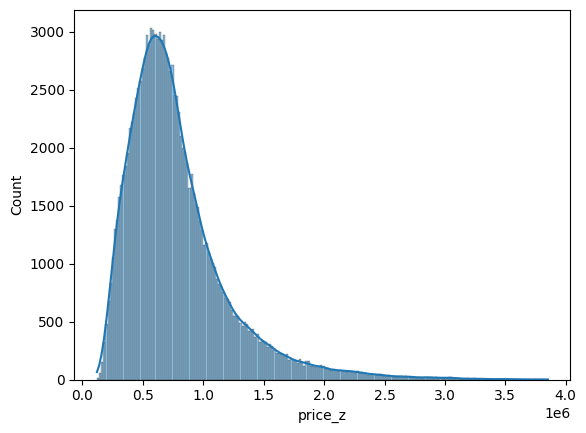

In [41]:
sns.histplot(encoded_train.price_z, kde=True)

In [45]:
# clearly right-skewed distribution - let's see
# how it looks after log transformation
# we use log(x + 1) in case of zeros in x

<Axes: xlabel='price_z', ylabel='Count'>

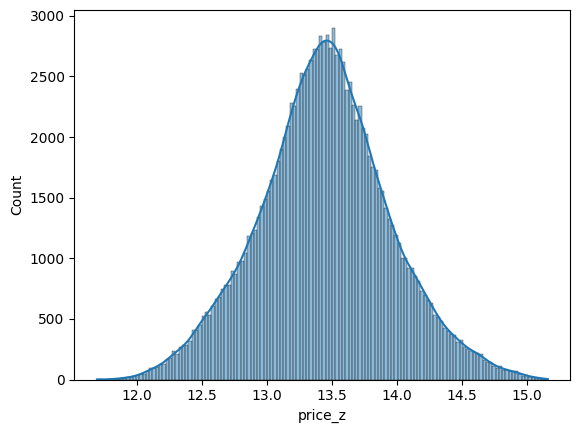

In [43]:
sns.histplot(np.log(encoded_train.price_z + 1), kde=True)

In [47]:
# much more "normal-like" - probably better for modelling

In [96]:
train_X_all = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 
     'dist_kind', 'dist_rest', 'dist_pharma', 'floor_max', 'neighborhood_crime_rate', 
    'popularity_index', 'green_space_ratio', 'global_economic_index'])
train_Y = encoded_train['price_z']

In [100]:
train_Y_log = np.log(
    encoded_train['price_z'] + 1
)
model_y_log = LinearRegression().fit(train_X_all, train_Y_log)

In [104]:
pred_train = pd.DataFrame()
pred_train['model_y_log'] = model_y_log.predict(train_X_all)
pred_train.head()

,model_y_log
0,14.036759
1,13.727516
2,12.983310
3,13.032724
4,13.021254


In [106]:
# remember that models lm2 operated on transformed prices.
# To calculate the real fitted value of these models one should reverse
# the transformation of the target variable
# if y2 = ln(y + 1)  then  y = exp (y2) - 1

# Clip predicted log values to avoid overflow in exp
pred_train['model_y_log'] = pred_train['model_y_log'].clip(upper=15.2)

# Apply inverse log
pred_train['price_pred'] = np.exp(pred_train['model_y_log']) - 1

pred_train.head()

,model_y_log,price_pred
0,14.036759,1.247632e+06
1,13.727516,9.157647e+05
2,12.983310,4.350899e+05
3,13.032724,4.571292e+05
4,13.021254,4.519161e+05


In [108]:
encoded_train.price_z.describe()

count    1.251630e+05
mean     7.841834e+05
std      4.286315e+05
min      1.196369e+05
25%      5.026919e+05
50%      6.902146e+05
75%      9.445603e+05
max      3.851902e+06
Name: price_z, dtype: float64

In [110]:
pred_test = pd.DataFrame()
pred_test['model_y_log'] = model_y_log.predict(train_X_all)

pred_test['model_y_log'] = np.exp(pred_test['model_y_log']) - 1
pred_test.head()

,model_y_log
0,1.247632e+06
1,9.157647e+05
2,4.350899e+05
3,4.571292e+05
4,4.519161e+05


In [112]:
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {'RMSE': rmse, 'MAE': mae, 'MedAE': medae, 'MAPE': mape, 'R2': r2}

In [116]:
# test_metrics = pd.DataFrame()

# for col in pred_test.columns:
#     test_metrics[col] = regression_metrics(encoded_test['price_z'], pred_test[col])

# test_metrics

In [140]:
X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 'dist_kind', 
                                      'dist_rest', 'dist_pharma', 'floor_max', 
                                      'neighborhood_crime_rate', 
                        'popularity_index', 'green_space_ratio', 'global_economic_index'])
y_train = encoded_train['price_z']
X_test = encoded_test.drop(columns=['price_z', 'dist_sch', 'dist_post', 
     'dist_kind', 'dist_rest', 'dist_pharma', 'floor_max', 'neighborhood_crime_rate', 
    'popularity_index', 'green_space_ratio', 'global_economic_index'])
y_test = encoded_test['price_z']

df_model1 = LinearRegression()
df_model1.fit(X_train, y_train)
y_pred = df_model1.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
mae = mean_absolute_error(y_train, y_pred)
medae = median_absolute_error(y_train, y_pred)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Median Absolute Error:', medae)

Mean Absolute Error: 73630.62028358316
Root Mean Squared Error: 97688.62783346929
Median Absolute Error: 59242.51557035383


In [142]:
# Apply log transform to target variables (adding a small constant to avoid log(0) issues)
y_train_log = np.log1p(encoded_train['price_z'])
y_test_log = np.log1p(encoded_test['price_z'])

# Drop columns as before
X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 'dist_kind', 
                                      'dist_rest', 'dist_pharma', 'floor_max', 
                                      'neighborhood_crime_rate', 
                                      'popularity_index', 'green_space_ratio', 'global_economic_index'])
X_test = encoded_test.drop(columns=['price_z', 'dist_sch', 'dist_post', 
                                   'dist_kind', 'dist_rest', 'dist_pharma', 'floor_max', 
                                   'neighborhood_crime_rate', 'popularity_index', 
                                   'green_space_ratio', 'global_economic_index'])

# Fit model on log-transformed target
df_model1 = LinearRegression()
df_model1.fit(X_train, y_train_log)

# Predict on training set and reverse log transform
y_train_pred_log = df_model1.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)  # reverse log1p transform

# Reverse actual target to original scale for metrics
y_train_true = encoded_train['price_z']

# Metrics on training set
rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
mae_train = mean_absolute_error(y_train_true, y_train_pred)
medae_train = median_absolute_error(y_train_true, y_train_pred)
print('Training set metrics:')
print('Mean Absolute Error:', mae_train)
print('Root Mean Squared Error:', rmse_train)
print('Median Absolute Error:', medae_train)

# Predict on test set and reverse log transform
y_test_pred_log = df_model1.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

# Actual test target on original scale
y_test_true = encoded_test['price_z']

# Metrics on test set
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
medae_test = median_absolute_error(y_test_true, y_test_pred)
print('\nTest set metrics:')
print('Mean Absolute Error:', mae_test)
print('Root Mean Squared Error:', rmse_test)
print('Median Absolute Error:', medae_test)

Training set metrics:
Mean Absolute Error: 135232.32030060192
Root Mean Squared Error: 430168.56940370915
Median Absolute Error: 75955.71999149711

Test set metrics:
Mean Absolute Error: 142261.5769595547
Root Mean Squared Error: 502939.335991179
Median Absolute Error: 76200.2382351089


In [144]:
rmse_log_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log))
mae_log_train = mean_absolute_error(y_train_log, y_train_pred_log)
print("Training log-scale RMSE:", rmse_log_train)
print("Training log-scale MAE:", mae_log_train)

rmse_log_test = np.sqrt(mean_squared_error(y_test_log, y_test_pred_log))
mae_log_test = mean_absolute_error(y_test_log, y_test_pred_log)
print("Test log-scale RMSE:", rmse_log_test)
print("Test log-scale MAE:", mae_log_test)

Training log-scale RMSE: 0.19875321929475132
Training log-scale MAE: 0.14782332993272898
Test log-scale RMSE: 0.20153928146743758
Test log-scale MAE: 0.1490163278491484


In [148]:
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(y * lmbda + 1, 1 / lmbda)

In [154]:
X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 'dist_kind', 
                                      'dist_rest', 'dist_pharma', 'floor_max', 
                                      'neighborhood_crime_rate', 
                                      'popularity_index', 'green_space_ratio', 'global_economic_index'])
X_test = encoded_test.drop(columns=['price_z', 'dist_sch', 'dist_post', 
                                   'dist_kind', 'dist_rest', 'dist_pharma', 'floor_max', 
                                   'neighborhood_crime_rate', 'popularity_index', 
                                   'green_space_ratio', 'global_economic_index'])

# Extract target
y_train = encoded_train['price_z']
y_test = encoded_test['price_z']

# Box-Cox requires strictly positive data, ensure that:
assert (y_train > 0).all(), "y_train contains zero or negative values"
assert (y_test > 0).all(), "y_test contains zero or negative values"

# Apply Box-Cox transform on training target, get lambda parameter
y_train_boxcox, fitted_lambda = stats.boxcox(y_train)

print(f"Fitted Box-Cox lambda: {fitted_lambda}")

# Fit model on Box-Cox transformed target
df_model1 = LinearRegression()
df_model1.fit(X_train, y_train_boxcox)

# Predict on training set (Box-Cox scale)
y_train_pred_boxcox = df_model1.predict(X_train)

# Inverse Box-Cox transform to get predictions back on original scale
y_train_pred = inv_boxcox(y_train_pred_boxcox, fitted_lambda)

# Metrics on training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
medae_train = median_absolute_error(y_train, y_train_pred)

print('Training set metrics:')
print('Mean Absolute Error:', mae_train)
print('Root Mean Squared Error:', rmse_train)
print('Median Absolute Error:', medae_train)

# Predict on test set (Box-Cox scale)
y_test_pred_boxcox = df_model1.predict(X_test)

# Inverse transform predictions
y_test_pred = inv_boxcox(y_test_pred_boxcox, fitted_lambda)

# Metrics on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
medae_test = median_absolute_error(y_test, y_test_pred)

print('\nTest set metrics:')
print('Mean Absolute Error:', mae_test)
print('Root Mean Squared Error:', rmse_test)
print('Median Absolute Error:', medae_test)

Fitted Box-Cox lambda: -0.03528850265080396
Training set metrics:
Mean Absolute Error: 142531.08728285407
Root Mean Squared Error: 500097.5647265882
Median Absolute Error: 77217.46428489964

Test set metrics:
Mean Absolute Error: 150837.75298856435
Root Mean Squared Error: 598659.6344294265
Median Absolute Error: 77289.16625048779


In [172]:
# Apply log transform to target variables (adding a small constant to avoid log(0) issues)
y_train_log = np.log1p(encoded_train['price_z'])
y_test_log = np.log1p(encoded_test['price_z'])

# Drop columns as before
X_train = encoded_train.drop(columns=['price_z', 'dist_sch', 'dist_post', 'dist_kind', 
                                      'dist_rest', 'dist_pharma', 'floor_max', 
                                      'neighborhood_crime_rate', 
                                      'popularity_index', 'green_space_ratio', 'global_economic_index'])
X_test = encoded_test.drop(columns=['price_z', 'dist_sch', 'dist_post', 
                                   'dist_kind', 'dist_rest', 'dist_pharma', 'floor_max', 
                                   'neighborhood_crime_rate', 'popularity_index', 
                                   'green_space_ratio', 'global_economic_index'])

# Fit model on log-transformed target
df_model1 = LinearRegression()
df_model1.fit(X_train, y_train_log)

# Predict on training set and clip predicted log values before inverse transform
y_train_pred_log = df_model1.predict(X_train)
y_train_pred_log_clipped = np.clip(y_train_pred_log, a_min=None, a_max=15)  # clip upper bound to avoid overflow
y_train_pred = np.expm1(y_train_pred_log_clipped)  # reverse log1p transform

# Actual training target
y_train_true = encoded_train['price_z']

# Metrics on training set
rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
mae_train = mean_absolute_error(y_train_true, y_train_pred)
medae_train = median_absolute_error(y_train_true, y_train_pred)
print('Training set metrics:')
print('Mean Absolute Error:', mae_train)
print('Root Mean Squared Error:', rmse_train)
print('Median Absolute Error:', medae_train)

# Predict on test set and clip predicted log values before inverse transform
y_test_pred_log = df_model1.predict(X_test)
y_test_pred_log_clipped = np.clip(y_test_pred_log, a_min=None, a_max=15)
y_test_pred = np.expm1(y_test_pred_log_clipped)

# Actual test target
y_test_true = encoded_test['price_z']

# Metrics on test set
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
medae_test = median_absolute_error(y_test_true, y_test_pred)
print('\nTest set metrics:')
print('Mean Absolute Error:', mae_test)
print('Root Mean Squared Error:', rmse_test)
print('Median Absolute Error:', medae_test)


Training set metrics:
Mean Absolute Error: 109704.14824711128
Root Mean Squared Error: 172056.06863025573
Median Absolute Error: 75866.67343852343

Test set metrics:
Mean Absolute Error: 110437.83575014705
Root Mean Squared Error: 172805.4096899234
Median Absolute Error: 76077.61774113355


In [176]:
X_train = sm.add_constant(X_train)
df_model1 = sm.OLS(y_train, X_train).fit()
print(df_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                price_z   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                 8.785e+04
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        22:28:37   Log-Likelihood:            -1.6157e+06
No. Observations:              125163   AIC:                         3.231e+06
Df Residuals:                  125136   BIC:                         3.232e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [178]:
encoded_train.describe()

,dim_m2,n_rooms,floor_max,dist_centre,n_poi,dist_sch,dist_post,dist_kind,dist_rest,dist_pharma,...,src_month_2024-04,src_month_2024-05,src_month_2024-06,obj_type_0c238f18,obj_type_0d6c4dfc,obj_type_2a6d5c01,obj_type_Unknown,own_type_12631efb,own_type_Other,own_type_bfb8fe10
count,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,...,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000
mean,58.655630,2.677285,5.302062,4.355607,20.638615,0.412300,0.514894,0.367159,0.344782,0.357119,...,0.098623,0.104136,0.110001,0.150460,0.468773,0.165081,0.215687,0.900354,0.000064,0.099582
std,23.230119,0.915402,3.306357,2.897307,24.288301,0.465999,0.501974,0.447419,0.465148,0.459513,...,0.298157,0.305438,0.312892,0.357523,0.499026,0.371255,0.411300,0.299529,0.007995,0.299443
min,18.780000,1.000000,1.000000,0.008000,0.000000,0.002000,0.001000,0.001000,0.001000,0.001000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.210000,2.000000,3.000000,2.002500,7.000000,0.174000,0.236000,0.154000,0.112000,0.140000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,54.180000,3.000000,4.000000,3.935000,14.000000,0.288000,0.391000,0.260000,0.226000,0.238000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,69.790000,3.000000,6.000000,6.126000,24.000000,0.469000,0.621000,0.419000,0.409000,0.406000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,186.240000,6.000000,29.000000,19.649000,212.000000,5.718000,5.864000,5.795000,5.904000,5.752000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Random Forest Model on Real Test Dataset Application

In [198]:
with open('rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

In [200]:
rf_model

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [204]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39114 entries, 0 to 39113
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   unit_id                     39114 non-null  object 
 1   obj_type                    30673 non-null  object 
 2   dim_m2                      39114 non-null  float64
 3   n_rooms                     39114 non-null  float64
 4   floor_no                    32218 non-null  float64
 5   floor_max                   38652 non-null  float64
 6   year_built                  32611 non-null  float64
 7   dist_centre                 39114 non-null  float64
 8   n_poi                       39114 non-null  float64
 9   dist_sch                    39076 non-null  float64
 10  dist_clinic                 38957 non-null  float64
 11  dist_post                   39054 non-null  float64
 12  dist_kind                   39070 non-null  float64
 13  dist_rest                   390

In [208]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125163 entries, 96871 to 121958
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   obj_type                    125163 non-null  object 
 1   dim_m2                      125163 non-null  float64
 2   n_rooms                     125163 non-null  float64
 3   floor_max                   125163 non-null  float64
 4   dist_centre                 125163 non-null  float64
 5   n_poi                       125163 non-null  float64
 6   dist_sch                    125163 non-null  float64
 7   dist_post                   125163 non-null  float64
 8   dist_kind                   125163 non-null  float64
 9   dist_rest                   125163 non-null  float64
 10  dist_pharma                 125163 non-null  float64
 11  own_type                    125163 non-null  object 
 12  has_park                    125163 non-null  object 
 13  has_balcony    

In [216]:
df_final_test_copy = df_final_test.copy()

In [277]:
df_final_test = df_final_test_copy.copy()

In [281]:
# Replace low-frequency levels in 'own_type' with 'Other' (threshold: <=150)
value_counts = df_final_test['own_type'].value_counts()
levels_to_replace = value_counts[value_counts <= 150].index
df_final_test['own_type'] = df_final_test['own_type'].replace(levels_to_replace, "Other")

In [283]:
# obj_type - fill NaN with 'Unknown'
df_final_test.obj_type.fillna('Unknown', inplace=True)

# floor_no - fill NaN with -1 (Unknown)
df_final_test.floor_no.fillna(-1, inplace=True)

# floor_max - fill NaN with median
df_final_test.floor_max.fillna(df_final_test.floor_max.median(), inplace=True)

# year_built - fill NaN with median
df_final_test.year_built.fillna(df_final_test.year_built.median(), inplace=True)

# dist_sch - fill NaN with median
df_final_test.dist_sch.fillna(df_final_test.dist_sch.median(), inplace=True)

# dist_clinic - fill NaN with median
df_final_test.dist_clinic.fillna(df_final_test.dist_clinic.median(), inplace=True)

# dist_post - fill NaN with median
df_final_test.dist_post.fillna(df_final_test.dist_post.median(), inplace=True)

# dist_kind - fill NaN with median
df_final_test.dist_kind.fillna(df_final_test.dist_kind.median(), inplace=True)

# dist_rest - fill NaN with median
df_final_test.dist_rest.fillna(df_final_test.dist_rest.median(), inplace=True)

# dist_uni - fill NaN with median
df_final_test.dist_uni.fillna(df_final_test.dist_uni.median(), inplace=True)

# dist_pharma - fill NaN with median
df_final_test.dist_pharma.fillna(df_final_test.dist_pharma.median(), inplace=True)

# build_mat - fill NaN with 'Unknown'
df_final_test.build_mat.fillna('Unknown', inplace=True)

# cond_class - fill NaN with 'Unknown'
df_final_test.cond_class.fillna('Unknown', inplace=True)

# has_lift - fill NaN with random choice of 'yes' or 'no' with equal probability
nan_mask = df_final_test['has_lift'].isna()
n_nan = nan_mask.sum()
df_final_test.loc[nan_mask, 'has_lift'] = np.random.choice(['yes', 'no'], size=n_nan, p=[0.5, 0.5])

# infrastructure_quality - fill NaN with median
df_final_test.infrastructure_quality.fillna(df_final_test.infrastructure_quality.median(), inplace=True)


In [285]:
print(df_train.columns)

Index(['obj_type', 'dim_m2', 'n_rooms', 'floor_max', 'dist_centre', 'n_poi',
       'dist_sch', 'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma',
       'own_type', 'has_park', 'has_balcony', 'has_lift', 'has_sec',
       'has_store', 'price_z', 'src_month', 'market_volatility',
       'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio',
       'estimated_maintenance_cost', 'global_economic_index'],
      dtype='object')


In [287]:
train_features = [
    'obj_type', 'dim_m2', 'n_rooms', 'floor_max', 'dist_centre', 'n_poi',
    'dist_sch', 'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma',
    'own_type', 'has_park', 'has_balcony', 'has_lift', 'has_sec',
    'has_store', 'src_month', 'market_volatility',
    'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio',
    'estimated_maintenance_cost', 'global_economic_index'
]

# Keep only the columns from df_final_test that are in train_features
df_final_test = df_final_test[train_features].copy()

In [289]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39114 entries, 0 to 39113
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   obj_type                    39114 non-null  object 
 1   dim_m2                      39114 non-null  float64
 2   n_rooms                     39114 non-null  float64
 3   floor_max                   39114 non-null  float64
 4   dist_centre                 39114 non-null  float64
 5   n_poi                       39114 non-null  float64
 6   dist_sch                    39114 non-null  float64
 7   dist_post                   39114 non-null  float64
 8   dist_kind                   39114 non-null  float64
 9   dist_rest                   39114 non-null  float64
 10  dist_pharma                 39114 non-null  float64
 11  own_type                    39114 non-null  object 
 12  has_park                    39114 non-null  object 
 13  has_balcony                 391

In [235]:
# categorical_variables_with_3_levels = ['obj_type', 'own_type']
# categorical_variables_with_2 = categorical_variables.to_list()
# categorical_variables_with_2.remove('obj_type')
# categorical_variables_with_2.remove('own_type')
# print(categorical_variables_with_3_levels)
# print(categorical_variables_with_2)

# # train - 2 levels
# encoded_train = pd.get_dummies(encoded_train,
#                                columns = categorical_variables_with_2,
#                                drop_first = True,
#                                dtype = int
#                                )

# # train - >3 levels
# encoded_train = pd.get_dummies(encoded_train,
#                                columns = categorical_variables_with_3_levels,
#                                drop_first = False,
#                                dtype = int
#                                )

In [291]:
categorical_variables = df_final_test.select_dtypes('object').columns

In [293]:
# Define your categorical variables groups
categorical_variables_with_3_levels = ['obj_type', 'own_type']
categorical_variables_with_2 = categorical_variables.to_list()
categorical_variables_with_2.remove('obj_type')
categorical_variables_with_2.remove('own_type')

# Encode 2-level categorical variables with drop_first=True
df_final_test_encoded = pd.get_dummies(
    df_final_test,
    columns=categorical_variables_with_2,
    drop_first=True,
    dtype=int
)

# Encode 3-level categorical variables with drop_first=False
df_final_test_encoded = pd.get_dummies(
    df_final_test_encoded,
    columns=categorical_variables_with_3_levels,
    drop_first=False,
    dtype=int
)

# # Keep only columns present in encoded_train (excluding target 'price_z')
# train_columns = encoded_train.columns.drop('price_z')  # or your target variable
#df_final_test_encoded = df_final_test_encoded.reindex(columns=train_columns, fill_value=0)


In [295]:
encoded_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125163 entries, 96871 to 121958
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   dim_m2                      125163 non-null  float64
 1   n_rooms                     125163 non-null  float64
 2   floor_max                   125163 non-null  float64
 3   dist_centre                 125163 non-null  float64
 4   n_poi                       125163 non-null  float64
 5   dist_sch                    125163 non-null  float64
 6   dist_post                   125163 non-null  float64
 7   dist_kind                   125163 non-null  float64
 8   dist_rest                   125163 non-null  float64
 9   dist_pharma                 125163 non-null  float64
 10  price_z                     125163 non-null  float64
 11  market_volatility           125163 non-null  float64
 12  neighborhood_crime_rate     125163 non-null  float64
 13  popularity_inde

In [297]:
df_final_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39114 entries, 0 to 39113
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dim_m2                      39114 non-null  float64
 1   n_rooms                     39114 non-null  float64
 2   floor_max                   39114 non-null  float64
 3   dist_centre                 39114 non-null  float64
 4   n_poi                       39114 non-null  float64
 5   dist_sch                    39114 non-null  float64
 6   dist_post                   39114 non-null  float64
 7   dist_kind                   39114 non-null  float64
 8   dist_rest                   39114 non-null  float64
 9   dist_pharma                 39114 non-null  float64
 10  market_volatility           39114 non-null  float64
 11  neighborhood_crime_rate     39114 non-null  float64
 12  popularity_index            39114 non-null  float64
 13  green_space_ratio           391

In [321]:
# had to remove some columns as my model was trained without them

In [301]:
cols_to_drop = ['dist_sch', 'dist_post', 'dist_kind', 'dist_rest', 'dist_pharma']
df_final_test_encoded = df_final_test_encoded.drop(
    columns=[col for col in cols_to_drop if col in df_final_test_encoded.columns]
)

In [303]:
predictions = rf_model.predict(df_final_test_encoded)

In [309]:
# Insert predictions as a new first column 'price_z_pred' in the original test dataframe
df_final_test.insert(loc=0, column='price_z_predicted', value=predictions)

In [319]:
df_final_test.head()

,price_z_predicted,obj_type,dim_m2,n_rooms,floor_max,dist_centre,n_poi,dist_sch,dist_post,dist_kind,...,has_lift,has_sec,has_store,src_month,market_volatility,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
0,594396.920883,0d6c4dfc,75.51,3.0,4.0,4.690,10.0,0.070,0.639,0.278,...,no,no,yes,2023-08,563934.93,74.32,34.58,1.0,32.09,105.344824
1,648568.113932,0c238f18,73.38,4.0,4.0,2.297,13.0,0.323,0.527,0.417,...,yes,no,no,2023-08,629517.22,2.53,49.96,1.0,17.23,105.345748
2,581321.096192,0c238f18,117.49,5.0,4.0,1.019,39.0,0.250,0.212,0.306,...,no,no,yes,2023-08,558287.39,69.03,49.51,1.0,25.56,105.540787
3,257699.536192,0d6c4dfc,39.61,2.0,10.0,3.965,11.0,0.048,0.881,0.255,...,yes,no,no,2023-08,241548.94,38.39,27.78,1.0,19.19,104.588730
4,310293.328452,0d6c4dfc,56.24,3.0,3.0,4.880,11.0,0.248,0.137,0.701,...,no,no,yes,2023-08,295729.62,25.11,56.67,1.0,9.11,105.139462


In [325]:
# Save dataframes
with open('final_test_appartments.pkl', 'wb') as f:
    pickle.dump(df_final_test, f)
with open('final_test_encoded_appartments.pkl', 'wb') as f:
    pickle.dump(df_final_test_encoded, f)

# Done ! Finally ! A lot of effort :)

In [5]:
# Load models
with open('final_test_appartments.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

In [7]:
test_dataset.head()

,price_z_predicted,obj_type,dim_m2,n_rooms,floor_max,dist_centre,n_poi,dist_sch,dist_post,dist_kind,...,has_lift,has_sec,has_store,src_month,market_volatility,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
0,594396.920883,0d6c4dfc,75.51,3.0,4.0,4.690,10.0,0.070,0.639,0.278,...,no,no,yes,2023-08,563934.93,74.32,34.58,1.0,32.09,105.344824
1,648568.113932,0c238f18,73.38,4.0,4.0,2.297,13.0,0.323,0.527,0.417,...,yes,no,no,2023-08,629517.22,2.53,49.96,1.0,17.23,105.345748
2,581321.096192,0c238f18,117.49,5.0,4.0,1.019,39.0,0.250,0.212,0.306,...,no,no,yes,2023-08,558287.39,69.03,49.51,1.0,25.56,105.540787
3,257699.536192,0d6c4dfc,39.61,2.0,10.0,3.965,11.0,0.048,0.881,0.255,...,yes,no,no,2023-08,241548.94,38.39,27.78,1.0,19.19,104.588730
4,310293.328452,0d6c4dfc,56.24,3.0,3.0,4.880,11.0,0.248,0.137,0.701,...,no,no,yes,2023-08,295729.62,25.11,56.67,1.0,9.11,105.139462


In [9]:
df_final_test = pd.read_csv('data/appartments_test.csv')

In [13]:
df_final_test['predicted_price'] = test_dataset['price_z_predicted'].values

In [15]:
df_final_test.head()

,unit_id,obj_type,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,...,src_month,loc_code,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index,predicted_price
0,553836e34a0d5d6b,0d6c4dfc,75.51,3.0,2.0,4.0,1997.0,4.690,10.0,0.070,...,2023-08,143768f7,563934.93,15.52,74.32,34.58,1.0,32.09,105.344824,594396.920883
1,e04d0521349583d9,0c238f18,73.38,4.0,4.0,4.0,1930.0,2.297,13.0,0.323,...,2023-08,143768f7,629517.22,89.16,2.53,49.96,1.0,17.23,105.345748,648568.113932
2,83179d073b8319db,0c238f18,117.49,5.0,2.0,4.0,1936.0,1.019,39.0,0.250,...,2023-08,143768f7,558287.39,129.36,69.03,49.51,1.0,25.56,105.540787,581321.096192
3,9af01b0ba6016d69,0d6c4dfc,39.61,2.0,6.0,10.0,1970.0,3.965,11.0,0.048,...,2023-08,143768f7,241548.94,50.81,38.39,27.78,1.0,19.19,104.588730,257699.536192
4,086cba055ca54004,0d6c4dfc,56.24,3.0,2.0,3.0,1970.0,4.880,11.0,0.248,...,2023-08,143768f7,295729.62,38.10,25.11,56.67,1.0,9.11,105.139462,310293.328452


In [17]:
# Keep only 'unit_id' and 'claim_status_pred' columns
df_test = df_final_test[['unit_id', 'predicted_price']]

# Save to CSV
df_test.to_csv('appartments_id_predictions.csv', index=False)
test_dataset.to_csv('apparments_full_predictions.csv', index = False)